# 1. Introduction


## About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
from keras.callbacks import EarlyStopping
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_boston
boston = load_boston()

Using TensorFlow backend.


The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [3]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Full Value Property Tax Rate|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. At the time regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

## 1.2 Adding more readable column names

In [5]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [6]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [8]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

#### Objective 1: Use descriptive statistics and plots to describe the Boston House Prices Dataset

In the section I will use descriptive statistics and plots to provide a summary of the dataset and describe it's main features. This is of course a compenent of any data analysis project and will also aid in the identifying the steps that need to be taken in the data pre-processing stage of implementing the machine learning model that is shown later in this project.

## 2.1 Basic Information 

Pandas "info()" method can tell us the counts of datapoints in each of the features and also show if there are any missing / null values in the dataset. As we can see below, there are no null values that will have to be dealt with.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


## 2.2 Measures of central tendancy and measures of spread / dispersion

Next we will look at the measures of central tendancy and the spread / dispersion of the data.

1. Measures of Central Tendancy attempt to give one number that best summarises the data. These include the mean/average, median and mode. 
2. Measures of spead / dispersion show the variability within the data. These include the range (max - min), standard deviation, variance, skewness, kurtosis etc.

Pandas "describe()" function quickly gives an overview of some of these key statistics for each of the features in the dataset.

In [10]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Looking at the means, range, and quartile values in the above tables indicates that some of the features have very unevenly distributed values. Especially the crime rate and number of black people per 1000 people. It is also worth noting that different features are operating on very different scales.

The above table does not give the mode (most commonly occuring value) for each of the features, but the Pandas "mode()" function can be used to get this.

In [11]:
df.mode()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.01501,0.0,18.1,0.0,0.538,5.713,100.0,3.4952,24.0,666.0,20.2,396.9,6.36,50.0
1,14.33370,NaN,NaN,NaN,NaN,6.127,NaN,NaN,NaN,NaN,NaN,NaN,7.79,NaN
2,NaN,NaN,NaN,NaN,NaN,6.167,NaN,NaN,NaN,NaN,NaN,NaN,8.05,NaN
3,NaN,NaN,NaN,NaN,NaN,6.229,NaN,NaN,NaN,NaN,NaN,NaN,14.10,NaN
4,NaN,NaN,NaN,NaN,NaN,6.405,NaN,NaN,NaN,NaN,NaN,NaN,18.13,NaN
5,NaN,NaN,NaN,NaN,NaN,6.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is worth noting that the most common Median House price is 50,000 which also happens to be the maximum value. This will need to be looked at more closely. Other features where the mode is equal to the max value include:
1. The % of houses in the area built before 1940 - The mode is 100%, but this is believable in an old city like Boston.
2. Number of accessible highways - The mode and max are 24. 
3. Number of Blacks per 1000 - the mode and max are 396.9, but for such a specific number it may only have occured twice to be counted as the mode. 
4. Percentage of industrial land - The max and mode are both 18.1. Again this will need to be looked at more closely to see if it's an error. 

In [12]:
df.median()

Crime_Rate          0.25651
%_Large_Plots       0.00000
%_Indus             9.69000
By_River            0.00000
NOX                 0.53800
Rooms               6.20850
%_Pre_1940         77.50000
Dist_to_Jobs        3.20745
Highway_Access      5.00000
Tax               330.00000
PTRatio            19.05000
Blks_per_1000     391.44000
%_Lower_Status     11.36000
Median_Val         21.20000
dtype: float64

Comparing the above median values of the features to the max and mins again gives the impression of some highly skewed / unevenly distributed data.

## 2.3 Distribution of values

Next we will plot the distribution of the values and see if that highlights any issue or outliers. Beginning with the target variable - Median Value of House Prices.

As can be seen from the above KDE and Boxplot, there is a cluster of outliers in the upper range of values. It may be better to remove these later.

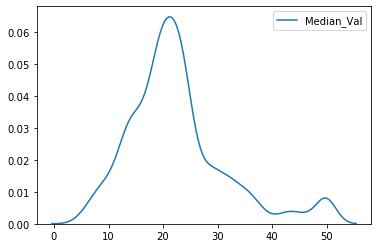

In [13]:
sns.kdeplot(df['Median_Val'])

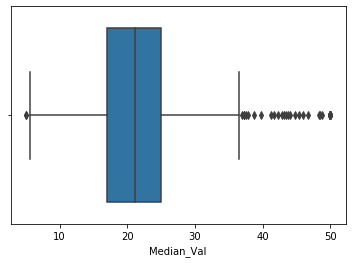

In [14]:
sns.boxplot(df['Median_Val'])

Looking at the all the features side by side, we can see that only Rooms, % of Lower Status people, Median Value are close to being normaly distributed. 

The "By_River" variable is a dummy variable with a boolean value. 

Crime rate, and the % of Large Plots have a large number of values close to zero which is understandable and doesn't set any alarm bells ringing about errors in the data.

The number of black people per 1000 tends towards the 40% mark, which again seems reasonable for a major US city and doesn't give any indication of errors in the data.

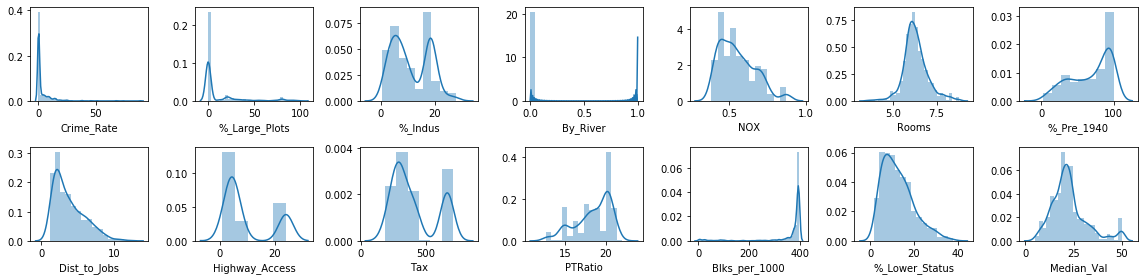

In [15]:
# distributions of the data
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.distplot(df[col[index]], ax = ax[i][j])
        index = index + 1

pyplt.tight_layout()

## 2.4 Relationships between the Variables

This next section will highlight any relationships between the data, beginning with creating a corrolation table.

In [16]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


As we can see from the above there are a number of variables that are strongly positively corrolated, for example:

1. Tax and access to highways (0.91) - understandable as highways are paid for out of taxes.
2. NOX and the % of Industrial Land (0.76) - not very suprising that industrial areas would have high levels of NOX. 
2. NOX and the % of Pre 1940 houses (0.73) - possibly older houses would be burning coal.
3. Tax and the % of Industrial Land (0.71) 

There are also some strongly negatively corrolated variables:

1. NOX and Distance to Jobs (-0.77) - makes sense as areas of employment are likely to be industrial and have more NOX. The further away you are, the better the air
2. % Pre 1940s houses and Distance to Jobs (-0.75) - makes sense as older areas are more likely to be located in the city centre near areas of employment. 
3. % Industrial and Distance to Jobs (-0.71) - same reasoning as point 1 above

In summary, there isn't anything unusual about the values in the corrolation table that requires further investigation. 

Looking more closely at the corrolation between the features and the target variable (Median House Prices), we can see that Rooms and % Lower Status are the most strongly corrolated. The rest of the variables are either moderately or weakly corrolated. This would indicate that the percentage of lower status people and the number of rooms are the best predictors of the housing prices. We will investigate this further later in this project.

In [17]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

Looking at below scatterplots of the different features vs the Median Value, Rooms and % of Lower Status People again stand out as having a relationship with it. 

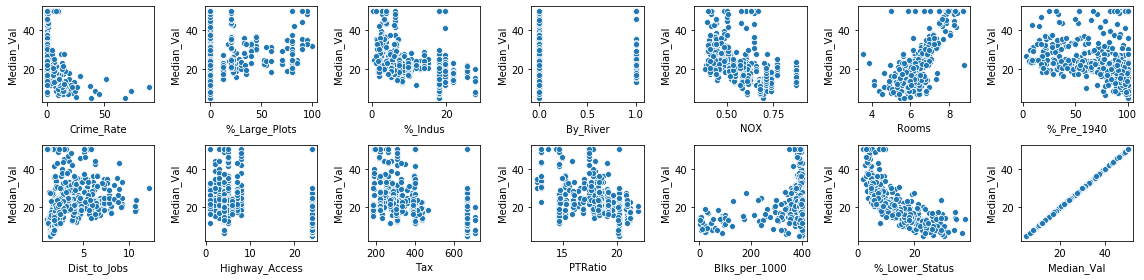

In [18]:
# scatter plots of the variables vs Median Value
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.scatterplot(df[col[index]], y="Median_Val", data=df, ax=ax[i][j])
        index = index + 1
        
        

pyplt.tight_layout()

Looking at the three most strongly corrolated values with the Median Value below, it's clear that the first two variables have a much more obvious relationship, while the Pupil Teacher ratio has much more noise.

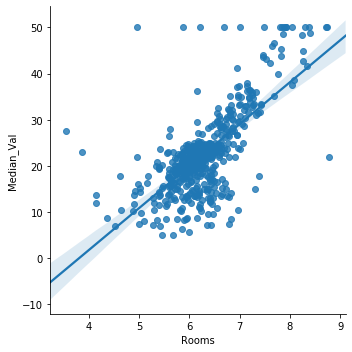

In [19]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

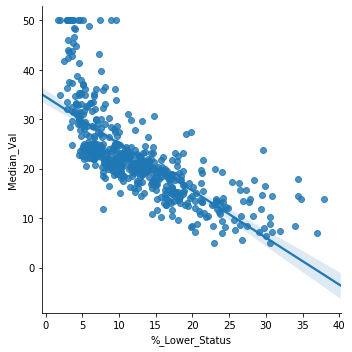

In [20]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

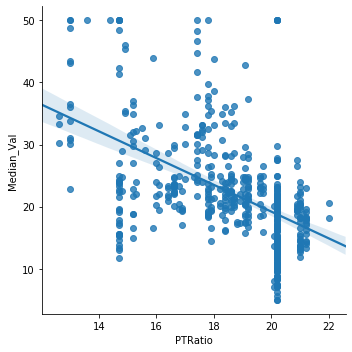

In [21]:
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

## 2.5 Conclusions from the Descriptive Analytics

My main conclusions or items of note from this section are:

1. There are no null values in the data that will need to be dealt with.
2. There are some potential errors / outliers in the Median Values with 14 values being at the max value of $50,000
3. The only other two variables with a normal distribution are also the most strongly corrolated with the Median Value

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below.

## 3.1 Looking more closely at the  "By_River" variable

As we can see from the below histogram, there are significantly more areas in our dataset that are located away from the Charles river than next to the Charles River (35).  (471)

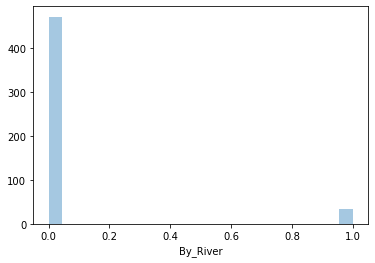

In [22]:
sns.distplot(df['By_River'], kde=False)

In [23]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [24]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

The exact count is:
* 35 next to the river 
* 471 away from the river

Looking at the distribution of the two categories we can see that the houses by the river would seems to have a higher percentage of more expensive houses. In addition, the cheapest house located away from the river.  

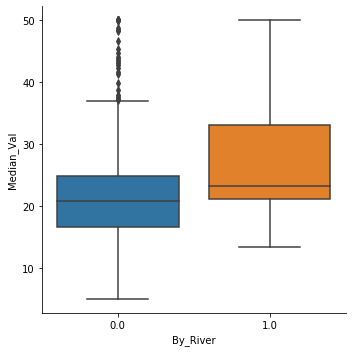

In [25]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

In [26]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]

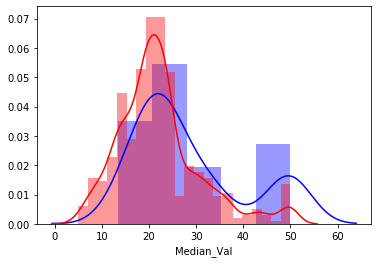

In [27]:
ax = sns.distplot(next_to_river['Median_Val'], color="blue")
ax = sns.distplot(away_from_river['Median_Val'], color="red")
pyplt.rcParams["figure.figsize"] = (20,20)

This is reflected in the descriptive statistics below with the "Next to River" values having a higher mean and mimimum value of than the areas that are located "Away from the River"

In [28]:
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [33]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

## 3.2 T-test

From the above plots and descriptive statistics it would seem that there does indeed to be some difference in the housing prices in areas along the Charles River vs those that aren't. A T-Test can be used to get futher confirmation of this (or indeed disprove this). 

### 3.2.1 Why use a T-Test?

A T-test is used to compare the means of two samples when the parameters of the population as a whole are not known. Using it will allow us to prove or reject the below Null Hypothosis and Alternative Hypothosis [14].

1. The Null Hypothesis is that there is no significant difference between houses along the Charles River and those that aren't.

2. The Alternative Hypothesis is that there is a significant difference between these two groups. 



### 3.2.2 T-Test Requirements

Before we can apply a T-Test, it is first necessary to ensure that our datasets meets the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale of 0-50|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

#### 3.2.2.1 Removing Outliers

As I mentioned earlier in this project, the "Median Val" variable has many outliers. This is clearly displayed in the Boxplot below. 

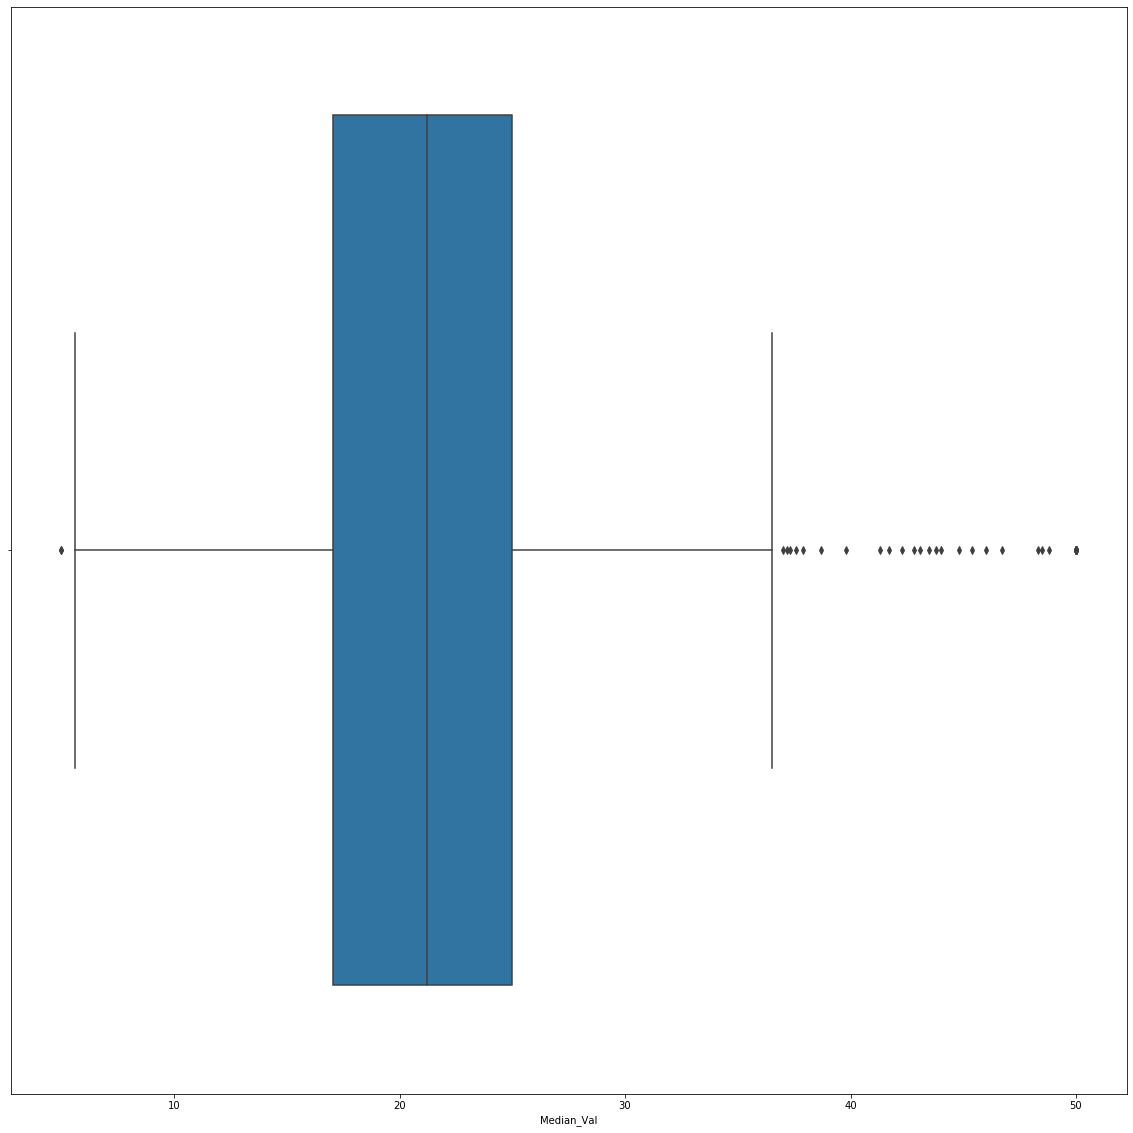

In [47]:
sns.boxplot(df['Median_Val'])

In [48]:
df["Median_Val"][df["Median_Val"] ==50].count()

16

There are also 16 areas where the median value of houses is $50,000, but nothing higher that this value. This could indicate  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers I have assigned a threshold for the Median Value, above or below which i have consider the data point to be an outlier. The most obvious way to do this is to follow the same method as the box-plot and remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [49]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [50]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [51]:
IQR = Q3 - Q1
IQR

7.975000000000001

Having calculated the interquartile range, this was then used find the upper and lower "whisker" values for the box plot which will acts as the "outlier thresholds".

In [52]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [53]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [54]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There were two data points below the lower threshold.

In [55]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [56]:
above["Median_Val"].count()

38

There were 38 datapoints that were higher that the upper threshold. Using these thresholds I created a dataset of data that was within these two thresholds called "no_outliers".

In [57]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Comparing the two groups with the outliers removed shows that the median values of the two groups was now much closer together, but the range of values in the "Away from River" group was still much wider.

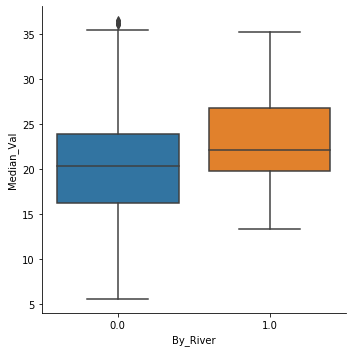

In [58]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

#### 3.2.2.2 Determining if the Dependant Variable is Approxmately Normally Distributed in Each Group.

In order to test this I created two new groups from the "no_outliers" dataset:
1. Next to River
2. Away from River

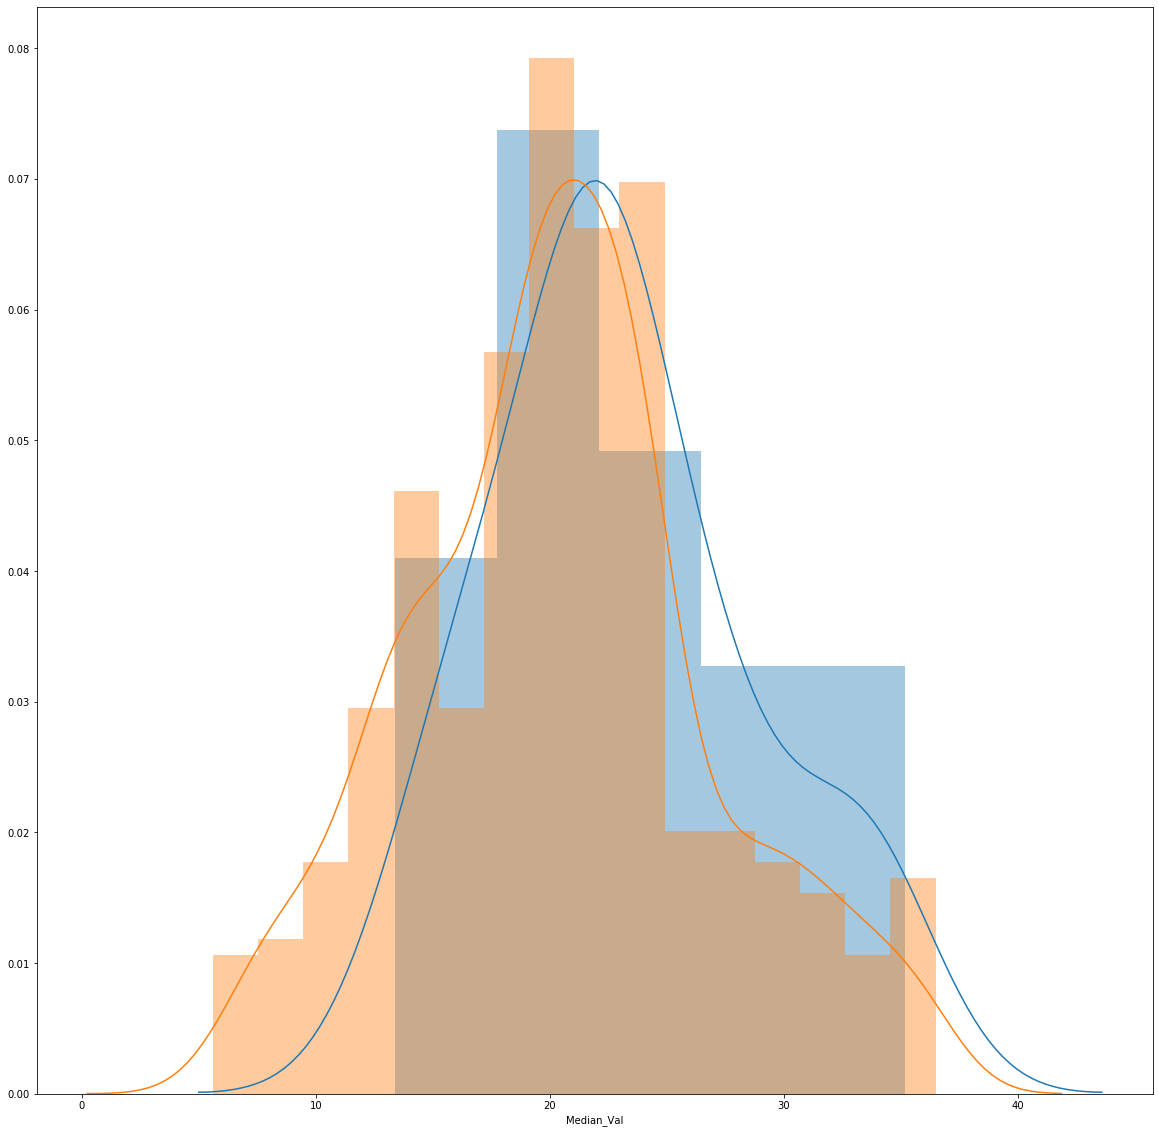

In [60]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" group it can be observed that both are much closer to appearing to be normally distributed than the original dataset with the outliers included.

I performed a further test using Scipys "normaltest" method to confirm this.

In [61]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). I can therefore be said the no significant departure from normality was found [15].

#### 3.2.2.3 Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid t-test it is necessary to check if both samples have similar variances. Levenes test can be used to do this. It tests the null hypothosis that variances are equal. 

In [62]:
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The P-value is greater than the threshold of 0.05 so it can be said that there is no signifcant difference in the variances of both groups.

In [63]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [64]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


#### 3.2.2.4 Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have been removed.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### 3.3 T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [44]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current section was to test if there is a significant difference in the Median Value of House Prices between the house prices in areas by or not by the Charles River in Boston.

In [65]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [46]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference < 0 p value =,0.9819
5,Difference > 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test showed a P-value of 0.0362. This is lower than the 0.05 threshold giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

We can thereforce conclude that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predicting House Price using a Neural Network


#### Objective 3: Predict the median house price based on the other variables in the dataset using neural network

## 4.1 Pre-Processing

Preprocessing is an integral step in Machine Learning. Quality of the data must be as good as possible before feeding into the model.

There are a number of different steps we can take to preprocesss the data and ensure the quality of the data:

1. Deal with any Null values
2. Deal with Categorical Variables
3. Standardise the Data


### 4.1.1 Null Values

First we will check to ensure if our cleansed dataset contains any Null values. If there are Null values, the row containing the value will be need to be removed of the value will need to be replaced.

In [47]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

As we can see, no of the columns contain Null values. So we can move on.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located by or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore we dont have to do any encoding or processing of this variable.

In [48]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise / Normalise the Data

In standardisation we transform all values such that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, if we look at the below we can see that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [49]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before we scale the data it needs to be split into the independent and dependent variables for the model.

It also a good idea to shuffle the data before going any further. 

In [50]:
no_outliers = shuffle(no_outliers)

In [51]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

The data then needs to be split into the testing and training sets. For this project we will use a 80:20 train:test split. 

We can use Sklearns model selection tool for this.

In [52]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [53]:
x_train.iloc[0]

Crime_Rate          0.22876
%_Large_Plots       0.00000
%_Indus             8.56000
By_River            0.00000
NOX                 0.52000
Rooms               6.40500
%_Pre_1940         85.40000
Dist_to_Jobs        2.71470
Highway_Access      5.00000
Tax               384.00000
PTRatio            20.90000
Blks_per_1000      70.80000
%_Lower_Status     10.63000
Name: 102, dtype: float64

Once the data is split into testing and training sets it can be scaled.


In [54]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [55]:
x_train.iloc[0]

Crime_Rate       -0.408692
%_Large_Plots    -0.498585
%_Indus          -0.414914
By_River         -0.268414
NOX              -0.315339
Rooms             0.367638
%_Pre_1940        0.622930
Dist_to_Jobs     -0.542385
Highway_Access   -0.548216
Tax              -0.183475
PTRatio           1.108191
Blks_per_1000    -2.941472
%_Lower_Status   -0.383619
Name: 0, dtype: float64

##  4.2 Baseline prediction test

At this stage I performed an inital test of the model to act as a performance baseline. I tuned this model further following this test.

In [56]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


In [57]:

m.fit(x_train, y_train, epochs=100, batch_size=5)

Epoch 1/100
372/372 [==============================] - 1s 3ms/step - loss: 468.4933
Epoch 2/100
372/372 [==============================] - 0s 244us/step - loss: 438.7146
Epoch 3/100
372/372 [==============================] - 0s 228us/step - loss: 406.7144
Epoch 4/100
372/372 [==============================] - 0s 223us/step - loss: 369.8574
Epoch 5/100
372/372 [==============================] - 0s 240us/step - loss: 325.5718
Epoch 6/100
372/372 [==============================] - 0s 212us/step - loss: 272.9422
Epoch 7/100
372/372 [==============================] - 0s 244us/step - loss: 218.0526
Epoch 8/100
372/372 [==============================] - 0s 225us/step - loss: 167.9353
Epoch 9/100
372/372 [==============================] - 0s 225us/step - loss: 127.0052
Epoch 10/100
372/372 [==============================] - 0s 211us/step - loss: 97.8453
Epoch 11/100
372/372 [==============================] - 0s 224us/step - loss: 77.2564
Epoch 12/100
372/372 [==============================] - 

Epoch 97/100
372/372 [==============================] - 0s 223us/step - loss: 5.6451
Epoch 98/100
372/372 [==============================] - 0s 216us/step - loss: 5.6377
Epoch 99/100
372/372 [==============================] - 0s 220us/step - loss: 5.6285
Epoch 100/100
372/372 [==============================] - 0s 209us/step - loss: 5.5753


In [58]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[31.461535, 34.889835, 21.171362, 20.200094, 23.433235, 17.208063,
        21.437021, 16.843723, 22.109371, 22.208372, 33.610054, 20.491137,
        24.416494, 29.50934 , 29.648525, 24.081577, 24.527681, 33.364468,
        26.364775, 19.429771, 25.079441, 16.255484, 18.98838 , 31.128887,
        20.890503, 18.094799,  9.23315 , 14.462807, 25.144772, 22.86633 ,
        22.672617, 16.14792 , 20.01243 , 27.340204, 19.20808 , 23.677696,
        25.457386, 12.20684 , 19.764977, 15.261866, 26.113619, 23.968084,
         8.253013, 26.981497, 25.651558, 26.609528, 19.482788, 15.568952,
        11.692653, 22.409256, 18.94233 , 30.781555, 14.677546, 15.606784,
        14.697543, 21.825209, 27.578949, 21.182878, 30.65956 , 20.569044,
        19.719818, 14.04311 , 16.347363, 15.807764, 17.331865, 28.476542,
        22.693752, 29.581646, 19.502415, 24.888098,  9.42799 , 15.861375,
        16.96409 , 16.529129, 16.671532, 23.05291 , 15.092644, 18.72091 ,
        17.670778, 25.20045 , 16.98772

In [59]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([36.2, 35.1, 16.6, 21.2, 23.1, 23.7, 23.2, 13.1, 20. , 20.8, 34.9,
       20.6, 22.8, 29.4, 33. , 25. , 22. , 36.5, 24.3, 18.7, 22.2, 17.8,
       14.4, 32. , 20.6, 13.8,  7.2, 11.7, 24.8, 24.1, 21.5, 13.8, 16.1,
       30.5, 19.4, 22.5, 28.7, 14.9, 18.8,  8.5, 25.1, 21.6,  7.4, 23.6,
       23.9, 22. , 16.8, 13.6,  8.1, 23.1, 22.6, 30.1, 11.5, 15. , 19.1,
       25. , 28.4, 20.2, 29. , 21. , 21. , 14.1, 18.1, 17.4, 17.3, 31.5,
       20.7, 29.9, 19.3, 22.1, 10.5, 18.9, 16. , 15.6, 15.1, 23.1, 20.2,
       20.5, 18.2, 25.3, 15.6, 18.2, 17.8, 16.2, 11.9, 14.9, 22.6, 21.4,
        8.3, 17.4, 22.6, 10.2, 22.9, 19.4], dtype=float32)

In [60]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,31.461535,36.200001,15.061142
1,34.889835,35.099998,0.602362
2,21.171362,16.600000,21.592194
3,20.200094,21.200001,4.950009
4,23.433235,23.100000,1.422061
...,...,...,...
89,19.648479,17.400000,11.443531
90,25.146080,22.600000,10.125155
91,12.665347,10.200000,19.465296
92,23.599602,22.900000,2.964466


In [61]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

10.880339

In [62]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 285us/step


7.032914466046273

## 4.3 Factors to Consider When Creating a Model

Before going any further it is worth outlining my reasoning for selecting the options that I did when creating this Baseline model and considerations for improving the model in later iterations.

#### Model Selection

I used the Sequential Model. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary what we are trying to achieve.

#### Density

This is the layer type. In this type all node/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). 

#### Number of Layers

For the baseline we have added 1 input later and 1 output layer. This is the absolute minimum number we can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models , having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I will introduce additional layers in later iterations of the model.

#### Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this case we have 13 input variables and required 1 output. This is what has been entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively reducing accuracy. 

There are some rules of thumb such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

These fail to take account of size of the training dataset and other considerations [3]. 

We will expriment with different unit sizes in later iterations.



#### Activation Function

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This is obviously not suitable for this projects dataset, but there are several others that are worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scalled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers of activated by the ReLU function. 
* ReLu should only be used in hidden layers.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left at the default linear function. 




#### Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error" [6].

#### Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I do not think there would be much value in using other optimizers.

#### Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In our Baseline Model we have set the model to perform 100 epochs. We will try larger numbers of epochs in later iterations. 

#### Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 


## 4.4 Model Tuning - Round 1

I will now test updating the model based on some of the possible improvements discussed above

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I will not be changing:
1. Activation functions
2. Loss function
3. Optimizer
From my investigation, the options in the Baseline Model already seem to be the best fit for the dataset.

### 4.4.1 Batch Sizes

###### Test 1-  Increasing Batch Size to 32


In [63]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=32)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch1 = m.evaluate(x_test, y_test)

In [64]:
# result_batch1

26.539871296984085

###### Test 2 - Batch Size to 16

In [65]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=16)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch2 = m.evaluate(x_test, y_test)

In [66]:
# result_batch2

12.633492307460054

###### Test 3 - Batch Size to 4

In [67]:
# Test 3
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=4)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch3 = m.evaluate(x_test, y_test)

In [68]:
# result_batch3

7.892184135761667

###### Test 4 - Batch Size to 2

In [69]:
# Test 4
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=2)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch4 = m.evaluate(x_test, y_test)

In [70]:
# result_batch4

8.877476955981965

#### 4.4.1.1 Commentary

I tested batch sizes multiple times and the results for 2 vs 4 batches was inconclusive. Sometimes 2 performed better and sometimes 4 performed better.

In order to get a more conclusive answer I test each five times and got the average of the tests.

In [71]:
# function to test batch sizes with 10 test and average of results

# def batchsize_test(tests, b_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")

#         m.fit(x_train, y_train, epochs=100, batch_size=b_size)

#         batch_test1_prediction = m.predict(x_test).T

#         MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_batch3 = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_batch3)
#     avg_result = sum(resultslist) / tests
#     return avg_result

#print(batchsize_test(5, 2))

In [72]:
#print(batchsize_test(5, 4))

###### Result of tests:

A batch size of 2 seems to perform marginally better. Given that we are dealing with a relatively small dataset memory isn't an issue so we should there is no reason not to use the smaller batch size. 

### 4.4.2 Number of Epochs

###### Test 1 - 500 Epochs

In [73]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# history = m.fit(x_train, y_train, epochs=500, batch_size=2)

# epoch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_epochv1 = m.evaluate(x_test, y_test)

In [74]:
# print(history.history.keys())

In [75]:
# pyplt.plot(history.history['loss'])
# pyplt.title('model loss')
# pyplt.ylabel('loss')
# pyplt.xlabel('epoch')
# pyplt.legend(['train', 'test'], loc='upper left')
# pyplt.show()

In [76]:
# result_epochv1

8.384088232162151

From looking at the above results there definitely seems to deminishing returns or even signs of overfitting after the 300 epoch mark. With that it may be best to introduce early stopping once the loss metric stops reducing.  

###### Test 2 - 500 Epochs with Early Stopping

In [77]:
# Test 2
# 
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

# ES_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_ES = m.evaluate(x_test, y_test)

In [78]:
# result_ES

8.051695742505663

#### 4.4.2.1 Commentary

Early stopping kicked in at before the 230 epoch mark in most test. This is even when the test was set to only stop when the loss value had no descresed for the previous 10 epochs.

In future there is probably no benefit to be gained from going over 250 Epochs

### 4.4.3 Number of Units per Layer

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. We will test this first.

In [79]:
14*(2/3)


9.333333333333332

In [80]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize9_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN9 = m.evaluate(x_test, y_test)

In [81]:
# result_layerN9

8.323373987319622

###### Test 2 - Twice the number of Inputs

One heuristics is that the number of units in the hidden layer should not be over twice the number of inputs.

In [82]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize26_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN26 = m.evaluate(x_test, y_test)

In [83]:
# result_layerN26

7.729459732136828

###### Test 3 - Quadrupel the Input

In [84]:
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize52_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN52 = m.evaluate(x_test, y_test)

In [85]:
# result_layerN52

5.981633308085989

Results appear inconclusive again. Need to test mutliple times and get an average.

In [86]:
# def unitsize_test(tests, batchsize, unit_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         #unit_prediction = m.predict(x_test).T

#         #MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_units = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_units)
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [87]:
# hidden layer size = 26
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 26))

Result was 8.461502002147919

In [88]:
# hidden layer size = 26
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 26))

Result was 7.670181302821382

In [89]:
# hidden layer size = 52
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 52))

Result was 8.024365358149751

In [90]:
# hidden layer size = 52
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 52))

Result was 7.862417864292226

In [91]:
# hidden layer size = 64
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 64))

Result was 8.067290689590129

In [92]:
# hidden layer size = 64
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 64))

Result was 7.880062107329673

The best result seems to be a hidden layer of 26 units and a batch size of 4 per epoch. Batch sizes of 4 seem to consistently perform better.

### 4.4.4 Number of Layers

To begin with we will test adding one additional hidden layer of various sizes.

In [93]:
def layer_count_test(tests, batchsize, unit_size1, unit_size2):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(unit_size2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        result_units = m.evaluate(x_test, y_test)
        
        counter += 1
        
        resultslist.append(result_units)
        #print("Version: " + tests, batchsize, unit_size1, unit_size2 + " iteration: " + counter)
        
    avg_result = sum(resultslist) / tests
    return avg_result

In [94]:
layers_test_results = [
    layer_count_test(5, 4, 13, 13),
    layer_count_test(5, 4, 26, 26),
    layer_count_test(5, 4, 26, 13),
    layer_count_test(5, 4, 52, 26),
    layer_count_test(5, 4, 64, 13),
]

Epoch 1/300
372/372 [==============================] - 0s 544us/step - loss: 435.9396
Epoch 2/300
372/372 [==============================] - 0s 352us/step - loss: 309.2825
Epoch 3/300
372/372 [==============================] - 0s 338us/step - loss: 125.4703
Epoch 4/300
372/372 [==============================] - 0s 330us/step - loss: 53.3348
Epoch 5/300
372/372 [==============================] - 0s 322us/step - loss: 26.8798
Epoch 6/300
372/372 [==============================] - 0s 336us/step - loss: 18.8394
Epoch 7/300
372/372 [==============================] - 0s 347us/step - loss: 15.9075
Epoch 8/300
372/372 [==============================] - 0s 276us/step - loss: 14.3371
Epoch 9/300
372/372 [==============================] - 0s 292us/step - loss: 13.2921
Epoch 10/300
372/372 [==============================] - 0s 294us/step - loss: 12.5319
Epoch 11/300
372/372 [==============================] - 0s 280us/step - loss: 11.9512
Epoch 12/300
372/372 [==============================] - 0s 2

Epoch 97/300
372/372 [==============================] - 0s 251us/step - loss: 5.1492
Epoch 98/300
372/372 [==============================] - 0s 268us/step - loss: 5.0875
Epoch 99/300
372/372 [==============================] - 0s 239us/step - loss: 5.0916
Epoch 100/300
372/372 [==============================] - 0s 257us/step - loss: 5.1528
Epoch 101/300
372/372 [==============================] - 0s 228us/step - loss: 5.1843
Epoch 102/300
372/372 [==============================] - 0s 214us/step - loss: 5.1773
Epoch 103/300
372/372 [==============================] - 0s 209us/step - loss: 5.2878
Epoch 104/300
372/372 [==============================] - 0s 244us/step - loss: 5.3106
Epoch 105/300
372/372 [==============================] - 0s 223us/step - loss: 5.1160
Epoch 106/300
372/372 [==============================] - 0s 230us/step - loss: 5.1260
Epoch 107/300
372/372 [==============================] - 0s 198us/step - loss: 5.0709
Epoch 108/300
372/372 [==============================] - 

372/372 [==============================] - 0s 425us/step - loss: 470.4184
Epoch 2/300
372/372 [==============================] - 0s 284us/step - loss: 402.7215
Epoch 3/300
372/372 [==============================] - 0s 322us/step - loss: 276.4376
Epoch 4/300
372/372 [==============================] - 0s 308us/step - loss: 131.1660
Epoch 5/300
372/372 [==============================] - 0s 283us/step - loss: 68.0942
Epoch 6/300
372/372 [==============================] - 0s 220us/step - loss: 44.7720
Epoch 7/300
372/372 [==============================] - 0s 215us/step - loss: 30.8933
Epoch 8/300
372/372 [==============================] - 0s 231us/step - loss: 22.8044
Epoch 9/300
372/372 [==============================] - 0s 225us/step - loss: 18.3591
Epoch 10/300
372/372 [==============================] - 0s 295us/step - loss: 15.8976
Epoch 11/300
372/372 [==============================] - 0s 279us/step - loss: 14.2984
Epoch 12/300
372/372 [==============================] - 0s 303us/step -

372/372 [==============================] - 0s 260us/step - loss: 3.8988
Epoch 193/300
372/372 [==============================] - 0s 214us/step - loss: 3.9501
Epoch 194/300
372/372 [==============================] - 0s 210us/step - loss: 3.8319
Epoch 195/300
372/372 [==============================] - 0s 239us/step - loss: 3.8381
Epoch 196/300
372/372 [==============================] - 0s 242us/step - loss: 3.7696
Epoch 197/300
372/372 [==============================] - 0s 244us/step - loss: 3.8969
Epoch 198/300
372/372 [==============================] - 0s 239us/step - loss: 3.8001
Epoch 199/300
372/372 [==============================] - 0s 244us/step - loss: 3.7616
Epoch 200/300
372/372 [==============================] - 0s 287us/step - loss: 3.8434
Epoch 201/300
372/372 [==============================] - 0s 267us/step - loss: 3.9083
Epoch 202/300
372/372 [==============================] - 0s 223us/step - loss: 3.7852
Epoch 203/300
372/372 [==============================] - 0s 225us/st

372/372 [==============================] - 0s 271us/step - loss: 3.7838
Epoch 144/300
372/372 [==============================] - 0s 298us/step - loss: 3.9164
Epoch 145/300
372/372 [==============================] - 0s 373us/step - loss: 3.8169
Epoch 146/300
372/372 [==============================] - 0s 343us/step - loss: 3.7969
Epoch 147/300
372/372 [==============================] - 0s 351us/step - loss: 3.7733
Epoch 148/300
372/372 [==============================] - 0s 273us/step - loss: 3.7872
Epoch 149/300
372/372 [==============================] - 0s 195us/step - loss: 3.7412
Epoch 150/300
372/372 [==============================] - 0s 232us/step - loss: 3.7329
Epoch 151/300
372/372 [==============================] - 0s 287us/step - loss: 3.7166
Epoch 152/300
372/372 [==============================] - 0s 244us/step - loss: 3.6701
Epoch 153/300
372/372 [==============================] - 0s 233us/step - loss: 3.6435
Epoch 154/300
372/372 [==============================] - 0s 216us/st

372/372 [==============================] - 0s 295us/step - loss: 4.3965
Epoch 136/300
372/372 [==============================] - 0s 316us/step - loss: 4.4346
Epoch 137/300
372/372 [==============================] - 0s 236us/step - loss: 4.4508
Epoch 138/300
372/372 [==============================] - 0s 228us/step - loss: 4.3742
Epoch 139/300
372/372 [==============================] - 0s 273us/step - loss: 4.3971
Epoch 140/300
372/372 [==============================] - 0s 306us/step - loss: 4.3548
Epoch 141/300
372/372 [==============================] - 0s 284us/step - loss: 4.4600
Epoch 142/300
372/372 [==============================] - 0s 235us/step - loss: 4.4425
Epoch 143/300
372/372 [==============================] - 0s 207us/step - loss: 4.3444
Epoch 144/300
372/372 [==============================] - 0s 243us/step - loss: 4.2923
Epoch 145/300
372/372 [==============================] - 0s 248us/step - loss: 4.3509
Epoch 146/300
372/372 [==============================] - 0s 239us/st

372/372 [==============================] - 0s 214us/step - loss: 4.9313
Epoch 68/300
372/372 [==============================] - 0s 201us/step - loss: 5.1466
Epoch 69/300
372/372 [==============================] - 0s 214us/step - loss: 5.0056
Epoch 70/300
372/372 [==============================] - 0s 233us/step - loss: 4.8610
Epoch 71/300
372/372 [==============================] - 0s 220us/step - loss: 4.9806
Epoch 72/300
372/372 [==============================] - 0s 214us/step - loss: 4.9953
Epoch 73/300
372/372 [==============================] - 0s 228us/step - loss: 5.0599
Epoch 74/300
372/372 [==============================] - 0s 217us/step - loss: 4.8923
Epoch 75/300
372/372 [==============================] - 0s 252us/step - loss: 4.9701
Epoch 76/300
372/372 [==============================] - 0s 228us/step - loss: 4.9809
Epoch 77/300
372/372 [==============================] - 0s 228us/step - loss: 4.8921
Epoch 78/300
372/372 [==============================] - 0s 213us/step - loss: 

372/372 [==============================] - 0s 255us/step - loss: 4.8406
Epoch 58/300
372/372 [==============================] - 0s 260us/step - loss: 4.8888
Epoch 59/300
372/372 [==============================] - 0s 248us/step - loss: 4.8361
Epoch 60/300
372/372 [==============================] - 0s 248us/step - loss: 4.7368
Epoch 61/300
372/372 [==============================] - 0s 256us/step - loss: 4.6676
Epoch 62/300
372/372 [==============================] - 0s 244us/step - loss: 4.7041
Epoch 63/300
372/372 [==============================] - 0s 260us/step - loss: 4.5584
Epoch 64/300
372/372 [==============================] - 0s 247us/step - loss: 4.5236
Epoch 65/300
372/372 [==============================] - 0s 255us/step - loss: 4.5638
Epoch 66/300
372/372 [==============================] - 0s 256us/step - loss: 4.6108
Epoch 67/300
372/372 [==============================] - 0s 268us/step - loss: 4.5111
Epoch 68/300
372/372 [==============================] - 0s 241us/step - loss: 

372/372 [==============================] - 0s 276us/step - loss: 1.9431
Epoch 248/300
372/372 [==============================] - 0s 266us/step - loss: 1.9360
Epoch 249/300
372/372 [==============================] - 0s 216us/step - loss: 1.8783
Epoch 250/300
372/372 [==============================] - 0s 240us/step - loss: 1.8727
Epoch 251/300
372/372 [==============================] - 0s 273us/step - loss: 1.8124
Epoch 252/300
372/372 [==============================] - 0s 338us/step - loss: 1.8989
Epoch 253/300
372/372 [==============================] - 0s 332us/step - loss: 1.8288
Epoch 254/300
372/372 [==============================] - 0s 300us/step - loss: 1.8577
Epoch 255/300
372/372 [==============================] - 0s 233us/step - loss: 1.8761
Epoch 256/300
372/372 [==============================] - 0s 235us/step - loss: 1.9366
Epoch 257/300
372/372 [==============================] - 0s 233us/step - loss: 1.8133
Epoch 258/300
372/372 [==============================] - 0s 249us/st

372/372 [==============================] - 0s 292us/step - loss: 2.7278
Epoch 139/300
372/372 [==============================] - 0s 300us/step - loss: 2.6855
Epoch 140/300
372/372 [==============================] - 0s 298us/step - loss: 2.6562
Epoch 141/300
372/372 [==============================] - 0s 250us/step - loss: 2.6380
Epoch 142/300
372/372 [==============================] - 0s 220us/step - loss: 2.6074
Epoch 143/300
372/372 [==============================] - 0s 308us/step - loss: 2.7188
Epoch 144/300
372/372 [==============================] - 0s 306us/step - loss: 2.6459
Epoch 145/300
372/372 [==============================] - 0s 300us/step - loss: 2.7152
Epoch 146/300
372/372 [==============================] - 0s 271us/step - loss: 2.6376
Epoch 147/300
372/372 [==============================] - 0s 239us/step - loss: 2.6994
Epoch 148/300
372/372 [==============================] - 0s 230us/step - loss: 2.4897
Epoch 149/300
372/372 [==============================] - 0s 236us/st

372/372 [==============================] - 0s 330us/step - loss: 2.7507
Epoch 121/300
372/372 [==============================] - 0s 349us/step - loss: 2.7022
Epoch 122/300
372/372 [==============================] - 0s 334us/step - loss: 2.6924
Epoch 123/300
372/372 [==============================] - 0s 336us/step - loss: 2.6205
Epoch 124/300
372/372 [==============================] - 0s 340us/step - loss: 2.6554
Epoch 125/300
372/372 [==============================] - 0s 346us/step - loss: 2.6983
Epoch 126/300
372/372 [==============================] - 0s 324us/step - loss: 2.7011
Epoch 127/300
372/372 [==============================] - 0s 349us/step - loss: 2.8419
Epoch 128/300
372/372 [==============================] - 0s 322us/step - loss: 2.6207
Epoch 129/300
372/372 [==============================] - 0s 311us/step - loss: 2.5939
Epoch 130/300
372/372 [==============================] - 0s 327us/step - loss: 2.6140
Epoch 131/300
372/372 [==============================] - 0s 319us/st

372/372 [==============================] - 0s 267us/step - loss: 6.9645
Epoch 21/300
372/372 [==============================] - 0s 233us/step - loss: 6.7064
Epoch 22/300
372/372 [==============================] - 0s 252us/step - loss: 6.6275
Epoch 23/300
372/372 [==============================] - 0s 466us/step - loss: 6.4842
Epoch 24/300
372/372 [==============================] - 0s 391us/step - loss: 6.4175
Epoch 25/300
372/372 [==============================] - 0s 241us/step - loss: 6.1641
Epoch 26/300
372/372 [==============================] - 0s 244us/step - loss: 6.2520
Epoch 27/300
372/372 [==============================] - 0s 220us/step - loss: 5.9543
Epoch 28/300
372/372 [==============================] - 0s 241us/step - loss: 5.9162
Epoch 29/300
372/372 [==============================] - 0s 236us/step - loss: 5.9611
Epoch 30/300
372/372 [==============================] - 0s 311us/step - loss: 5.8017
Epoch 31/300
372/372 [==============================] - 0s 335us/step - loss: 

372/372 [==============================] - 0s 252us/step - loss: 17.4605
Epoch 6/300
372/372 [==============================] - 0s 247us/step - loss: 14.5921
Epoch 7/300
372/372 [==============================] - 0s 292us/step - loss: 12.7156
Epoch 8/300
372/372 [==============================] - 0s 240us/step - loss: 11.6911
Epoch 9/300
372/372 [==============================] - 0s 241us/step - loss: 10.6053
Epoch 10/300
372/372 [==============================] - 0s 285us/step - loss: 9.9990
Epoch 11/300
372/372 [==============================] - 0s 290us/step - loss: 9.4560
Epoch 12/300
372/372 [==============================] - 0s 287us/step - loss: 8.9081
Epoch 13/300
372/372 [==============================] - 0s 239us/step - loss: 8.6233
Epoch 14/300
372/372 [==============================] - 0s 235us/step - loss: 8.3213
Epoch 15/300
372/372 [==============================] - 0s 268us/step - loss: 8.0183
Epoch 16/300
372/372 [==============================] - 0s 268us/step - loss:

372/372 [==============================] - 0s 228us/step - loss: 9.2158
Epoch 17/300
372/372 [==============================] - 0s 216us/step - loss: 8.7452
Epoch 18/300
372/372 [==============================] - 0s 253us/step - loss: 8.5027
Epoch 19/300
372/372 [==============================] - 0s 243us/step - loss: 8.2481
Epoch 20/300
372/372 [==============================] - 0s 246us/step - loss: 8.0465
Epoch 21/300
372/372 [==============================] - 0s 238us/step - loss: 7.8809
Epoch 22/300
372/372 [==============================] - 0s 240us/step - loss: 7.7266
Epoch 23/300
372/372 [==============================] - 0s 233us/step - loss: 7.5321
Epoch 24/300
372/372 [==============================] - 0s 279us/step - loss: 7.3384
Epoch 25/300
372/372 [==============================] - 0s 320us/step - loss: 7.1102
Epoch 26/300
372/372 [==============================] - 0s 271us/step - loss: 6.9766
Epoch 27/300
372/372 [==============================] - 0s 263us/step - loss: 

372/372 [==============================] - 0s 405us/step - loss: 2.5114
Epoch 208/300
372/372 [==============================] - 0s 290us/step - loss: 2.4782
Epoch 209/300
372/372 [==============================] - 0s 192us/step - loss: 2.4433
Epoch 210/300
372/372 [==============================] - 0s 221us/step - loss: 2.5227
Epoch 211/300
372/372 [==============================] - 0s 235us/step - loss: 2.5077
Epoch 212/300
372/372 [==============================] - 0s 225us/step - loss: 2.4630
Epoch 213/300
372/372 [==============================] - 0s 243us/step - loss: 2.5031
Epoch 214/300
372/372 [==============================] - 0s 375us/step - loss: 2.4830
Epoch 215/300
372/372 [==============================] - 0s 445us/step - loss: 2.5441
Epoch 216/300
372/372 [==============================] - 0s 276us/step - loss: 2.3954
Epoch 217/300
372/372 [==============================] - 0s 209us/step - loss: 2.4682
Epoch 218/300
372/372 [==============================] - 0s 263us/st

372/372 [==============================] - 0s 253us/step - loss: 2.9948
Epoch 164/300
372/372 [==============================] - 0s 324us/step - loss: 2.8773
Epoch 165/300
372/372 [==============================] - 0s 278us/step - loss: 2.9707
Epoch 166/300
372/372 [==============================] - 0s 218us/step - loss: 2.8724
Epoch 167/300
372/372 [==============================] - 0s 249us/step - loss: 2.7958
Epoch 168/300
372/372 [==============================] - 0s 292us/step - loss: 2.9405
Epoch 169/300
372/372 [==============================] - 0s 308us/step - loss: 2.7440
Epoch 170/300
372/372 [==============================] - 0s 218us/step - loss: 2.7953
Epoch 171/300
372/372 [==============================] - 0s 223us/step - loss: 2.8693
Epoch 172/300
372/372 [==============================] - 0s 249us/step - loss: 2.8752
Epoch 173/300
372/372 [==============================] - 0s 236us/step - loss: 2.8301
Epoch 174/300
372/372 [==============================] - 0s 254us/st

372/372 [==============================] - 0s 247us/step - loss: 6.7264
Epoch 21/300
372/372 [==============================] - 0s 231us/step - loss: 6.5766
Epoch 22/300
372/372 [==============================] - 0s 240us/step - loss: 6.5006
Epoch 23/300
372/372 [==============================] - 0s 249us/step - loss: 6.3265
Epoch 24/300
372/372 [==============================] - 0s 260us/step - loss: 6.1698
Epoch 25/300
372/372 [==============================] - 0s 247us/step - loss: 6.1142
Epoch 26/300
372/372 [==============================] - 0s 231us/step - loss: 5.9623
Epoch 27/300
372/372 [==============================] - 0s 292us/step - loss: 6.0282
Epoch 28/300
372/372 [==============================] - 0s 295us/step - loss: 5.9912
Epoch 29/300
372/372 [==============================] - 0s 276us/step - loss: 5.6719
Epoch 30/300
372/372 [==============================] - 0s 252us/step - loss: 5.7449
Epoch 31/300
372/372 [==============================] - 0s 204us/step - loss: 

372/372 [==============================] - 0s 233us/step - loss: 6.5389
Epoch 28/300
372/372 [==============================] - 0s 246us/step - loss: 6.5250
Epoch 29/300
372/372 [==============================] - 0s 224us/step - loss: 6.4583
Epoch 30/300
372/372 [==============================] - 0s 231us/step - loss: 6.3298
Epoch 31/300
372/372 [==============================] - 0s 239us/step - loss: 6.2100
Epoch 32/300
372/372 [==============================] - 0s 221us/step - loss: 6.2820
Epoch 33/300
372/372 [==============================] - 0s 220us/step - loss: 6.3359
Epoch 34/300
372/372 [==============================] - 0s 223us/step - loss: 6.0877
Epoch 35/300
372/372 [==============================] - 0s 232us/step - loss: 6.0895
Epoch 36/300
372/372 [==============================] - 0s 224us/step - loss: 5.9492
Epoch 37/300
372/372 [==============================] - 0s 230us/step - loss: 5.9436
Epoch 38/300
372/372 [==============================] - 0s 239us/step - loss: 

Epoch 123/300
372/372 [==============================] - 0s 239us/step - loss: 3.5717
Epoch 124/300
372/372 [==============================] - 0s 224us/step - loss: 3.5758
Epoch 125/300
372/372 [==============================] - 0s 216us/step - loss: 3.5214
Epoch 126/300
372/372 [==============================] - 0s 226us/step - loss: 3.4242
Epoch 127/300
372/372 [==============================] - 0s 232us/step - loss: 3.4504
Epoch 128/300
372/372 [==============================] - 0s 237us/step - loss: 3.5704
Epoch 129/300
372/372 [==============================] - 0s 239us/step - loss: 3.4055
Epoch 130/300
372/372 [==============================] - 0s 227us/step - loss: 3.4158
Epoch 131/300
372/372 [==============================] - 0s 235us/step - loss: 3.3867
Epoch 132/300
372/372 [==============================] - 0s 238us/step - loss: 3.5049
Epoch 133/300
372/372 [==============================] - 0s 228us/step - loss: 3.4172
Epoch 134/300
372/372 [==============================]

Epoch 13/300
372/372 [==============================] - 0s 220us/step - loss: 7.1675
Epoch 14/300
372/372 [==============================] - 0s 219us/step - loss: 6.9444
Epoch 15/300
372/372 [==============================] - 0s 233us/step - loss: 6.8062
Epoch 16/300
372/372 [==============================] - 0s 248us/step - loss: 6.7453
Epoch 17/300
372/372 [==============================] - 0s 241us/step - loss: 6.3006
Epoch 18/300
372/372 [==============================] - 0s 215us/step - loss: 6.4953
Epoch 19/300
372/372 [==============================] - 0s 309us/step - loss: 6.2258
Epoch 20/300
372/372 [==============================] - 0s 270us/step - loss: 6.0878
Epoch 21/300
372/372 [==============================] - 0s 273us/step - loss: 6.0274
Epoch 22/300
372/372 [==============================] - 0s 245us/step - loss: 5.8916
Epoch 23/300
372/372 [==============================] - 0s 233us/step - loss: 5.8873
Epoch 24/300
372/372 [==============================] - 0s 262us/

372/372 [==============================] - 0s 244us/step - loss: 1.3336
Epoch 205/300
372/372 [==============================] - 0s 314us/step - loss: 1.3670
Epoch 206/300
372/372 [==============================] - 0s 262us/step - loss: 1.3737
Epoch 207/300
372/372 [==============================] - 0s 225us/step - loss: 1.2664
Epoch 208/300
372/372 [==============================] - 0s 253us/step - loss: 1.4118
Epoch 209/300
372/372 [==============================] - 0s 285us/step - loss: 1.3778
Epoch 210/300
372/372 [==============================] - 0s 256us/step - loss: 1.2156
Epoch 211/300
372/372 [==============================] - 0s 275us/step - loss: 1.2489
Epoch 212/300
372/372 [==============================] - 0s 276us/step - loss: 1.2957
Epoch 213/300
372/372 [==============================] - 0s 293us/step - loss: 1.2586
Epoch 214/300
372/372 [==============================] - 0s 252us/step - loss: 1.2653
Epoch 215/300
372/372 [==============================] - 0s 271us/st

372/372 [==============================] - 0s 214us/step - loss: 2.1287
Epoch 157/300
372/372 [==============================] - 0s 242us/step - loss: 2.1491
Epoch 158/300
372/372 [==============================] - 0s 215us/step - loss: 2.1620
Epoch 159/300
372/372 [==============================] - 0s 233us/step - loss: 2.1421
Epoch 160/300
372/372 [==============================] - 0s 240us/step - loss: 2.0045
Epoch 161/300
372/372 [==============================] - 0s 249us/step - loss: 2.0534
Epoch 162/300
372/372 [==============================] - 0s 253us/step - loss: 2.0885
Epoch 163/300
372/372 [==============================] - 0s 244us/step - loss: 1.9796
Epoch 164/300
372/372 [==============================] - 0s 249us/step - loss: 2.0594
Epoch 165/300
372/372 [==============================] - 0s 221us/step - loss: 2.0954
Epoch 166/300
372/372 [==============================] - 0s 260us/step - loss: 2.0653
Epoch 167/300
372/372 [==============================] - 0s 238us/st

Epoch 107/300
372/372 [==============================] - 0s 292us/step - loss: 2.5576
Epoch 108/300
372/372 [==============================] - 0s 295us/step - loss: 2.6068
Epoch 109/300
372/372 [==============================] - 0s 268us/step - loss: 2.6541
Epoch 110/300
372/372 [==============================] - 0s 286us/step - loss: 2.5901
Epoch 111/300
372/372 [==============================] - 0s 279us/step - loss: 2.4389
Epoch 112/300
372/372 [==============================] - 0s 226us/step - loss: 2.5710
Epoch 113/300
372/372 [==============================] - 0s 263us/step - loss: 2.3947
Epoch 114/300
372/372 [==============================] - 0s 257us/step - loss: 2.4732
Epoch 115/300
372/372 [==============================] - 0s 260us/step - loss: 2.5492
Epoch 116/300
372/372 [==============================] - 0s 225us/step - loss: 2.4620
Epoch 117/300
372/372 [==============================] - 0s 279us/step - loss: 2.3837
Epoch 118/300
372/372 [==============================]

372/372 [==============================] - 0s 225us/step - loss: 1.7874
Epoch 142/300
372/372 [==============================] - 0s 249us/step - loss: 1.7106
Epoch 143/300
372/372 [==============================] - 0s 242us/step - loss: 1.8174
Epoch 144/300
372/372 [==============================] - 0s 236us/step - loss: 1.7776
Epoch 145/300
372/372 [==============================] - 0s 250us/step - loss: 1.7802
Epoch 146/300
372/372 [==============================] - 0s 248us/step - loss: 1.7987
Epoch 147/300
372/372 [==============================] - 0s 359us/step - loss: 1.7219
Epoch 148/300
372/372 [==============================] - 0s 243us/step - loss: 1.6704
Epoch 149/300
372/372 [==============================] - 0s 286us/step - loss: 1.6846
Epoch 150/300
372/372 [==============================] - 0s 290us/step - loss: 1.6203
Epoch 151/300
372/372 [==============================] - 0s 252us/step - loss: 1.5664
Epoch 152/300
372/372 [==============================] - 0s 238us/st

372/372 [==============================] - 0s 236us/step - loss: 1.9661
Epoch 171/300
372/372 [==============================] - 0s 239us/step - loss: 1.9615
Epoch 172/300
372/372 [==============================] - 0s 245us/step - loss: 1.9722
Epoch 173/300
372/372 [==============================] - 0s 241us/step - loss: 1.8409
Epoch 174/300
372/372 [==============================] - 0s 249us/step - loss: 1.8966
Epoch 175/300
372/372 [==============================] - 0s 232us/step - loss: 1.8482
Epoch 176/300
372/372 [==============================] - 0s 266us/step - loss: 1.8962
Epoch 177/300
372/372 [==============================] - 0s 235us/step - loss: 1.8658
Epoch 178/300
372/372 [==============================] - 0s 228us/step - loss: 1.8375
Epoch 179/300
372/372 [==============================] - 0s 244us/step - loss: 1.8405
Epoch 180/300
372/372 [==============================] - 0s 243us/step - loss: 1.8853
Epoch 181/300
372/372 [==============================] - 0s 239us/st

Epoch 46/300
372/372 [==============================] - 0s 257us/step - loss: 4.5715
Epoch 47/300
372/372 [==============================] - 0s 236us/step - loss: 4.7965
Epoch 48/300
372/372 [==============================] - 0s 238us/step - loss: 4.5242
Epoch 49/300
372/372 [==============================] - 0s 238us/step - loss: 4.5400
Epoch 50/300
372/372 [==============================] - 0s 238us/step - loss: 4.7498
Epoch 51/300
372/372 [==============================] - 0s 250us/step - loss: 4.5149
Epoch 52/300
372/372 [==============================] - 0s 240us/step - loss: 4.2917
Epoch 53/300
372/372 [==============================] - 0s 225us/step - loss: 4.2451
Epoch 54/300
372/372 [==============================] - 0s 233us/step - loss: 4.2976
Epoch 55/300
372/372 [==============================] - 0s 216us/step - loss: 4.2758
Epoch 56/300
372/372 [==============================] - 0s 244us/step - loss: 4.4949
Epoch 57/300
372/372 [==============================] - 0s 296us/

372/372 [==============================] - 0s 239us/step - loss: 1.8175
Epoch 237/300
372/372 [==============================] - 0s 244us/step - loss: 1.7328
Epoch 238/300
372/372 [==============================] - 0s 225us/step - loss: 1.7643
Epoch 239/300
372/372 [==============================] - 0s 247us/step - loss: 1.7101
Epoch 240/300
372/372 [==============================] - 0s 247us/step - loss: 1.7938
Epoch 241/300
372/372 [==============================] - 0s 231us/step - loss: 1.7388
Epoch 242/300
372/372 [==============================] - 0s 236us/step - loss: 1.8824
Epoch 243/300
372/372 [==============================] - 0s 240us/step - loss: 1.8166
Epoch 244/300
372/372 [==============================] - 0s 233us/step - loss: 1.9100
Epoch 245/300
372/372 [==============================] - 0s 233us/step - loss: 1.6757
Epoch 246/300
372/372 [==============================] - 0s 220us/step - loss: 1.7046
Epoch 247/300
372/372 [==============================] - 0s 263us/st

Epoch 16/300
372/372 [==============================] - 0s 244us/step - loss: 7.6199
Epoch 17/300
372/372 [==============================] - 0s 255us/step - loss: 7.3738
Epoch 18/300
372/372 [==============================] - 0s 284us/step - loss: 7.1093
Epoch 19/300
372/372 [==============================] - 0s 256us/step - loss: 6.9293
Epoch 20/300
372/372 [==============================] - 0s 306us/step - loss: 6.7626
Epoch 21/300
372/372 [==============================] - 0s 306us/step - loss: 6.6327
Epoch 22/300
372/372 [==============================] - 0s 281us/step - loss: 6.4192
Epoch 23/300
372/372 [==============================] - 0s 273us/step - loss: 6.2558
Epoch 24/300
372/372 [==============================] - 0s 208us/step - loss: 6.2361
Epoch 25/300
372/372 [==============================] - 0s 232us/step - loss: 6.1425
Epoch 26/300
372/372 [==============================] - 0s 244us/step - loss: 6.0129
Epoch 27/300
372/372 [==============================] - 0s 287us/

372/372 [==============================] - 0s 230us/step - loss: 1.9641
Epoch 208/300
372/372 [==============================] - 0s 232us/step - loss: 1.9100
Epoch 209/300
372/372 [==============================] - 0s 239us/step - loss: 2.0202
Epoch 210/300
372/372 [==============================] - 0s 244us/step - loss: 2.0613
Epoch 211/300
372/372 [==============================] - 0s 232us/step - loss: 1.8542
Epoch 212/300
372/372 [==============================] - 0s 238us/step - loss: 1.8816
Epoch 213/300
372/372 [==============================] - 0s 241us/step - loss: 1.9385
Epoch 214/300
372/372 [==============================] - 0s 232us/step - loss: 1.8656
Epoch 215/300
372/372 [==============================] - 0s 259us/step - loss: 1.8517
Epoch 216/300
372/372 [==============================] - 0s 228us/step - loss: 1.7966
Epoch 217/300
372/372 [==============================] - 0s 236us/step - loss: 1.8155
Epoch 218/300
372/372 [==============================] - 0s 265us/st

372/372 [==============================] - 0s 251us/step - loss: 3.2501
Epoch 103/300
372/372 [==============================] - 0s 263us/step - loss: 3.3327
Epoch 104/300
372/372 [==============================] - 0s 253us/step - loss: 3.3481
Epoch 105/300
372/372 [==============================] - 0s 243us/step - loss: 3.3829
Epoch 106/300
372/372 [==============================] - 0s 248us/step - loss: 3.2611
Epoch 107/300
372/372 [==============================] - 0s 249us/step - loss: 3.3898
Epoch 108/300
372/372 [==============================] - 0s 249us/step - loss: 3.3534
Epoch 109/300
372/372 [==============================] - 0s 257us/step - loss: 3.4369
Epoch 110/300
372/372 [==============================] - 0s 262us/step - loss: 3.2405
Epoch 111/300
372/372 [==============================] - 0s 235us/step - loss: 3.3607
Epoch 112/300
372/372 [==============================] - 0s 263us/step - loss: 3.3296
Epoch 113/300
372/372 [==============================] - 0s 259us/st

372/372 [==============================] - 0s 219us/step - loss: 4.1503
Epoch 55/300
372/372 [==============================] - 0s 231us/step - loss: 4.1315
Epoch 56/300
372/372 [==============================] - 0s 249us/step - loss: 4.1835
Epoch 57/300
372/372 [==============================] - 0s 240us/step - loss: 4.0000
Epoch 58/300
372/372 [==============================] - 0s 219us/step - loss: 4.0250
Epoch 59/300
372/372 [==============================] - 0s 262us/step - loss: 4.0796
Epoch 60/300
372/372 [==============================] - 0s 271us/step - loss: 4.1809
Epoch 61/300
372/372 [==============================] - 0s 263us/step - loss: 3.9991
Epoch 62/300
372/372 [==============================] - 0s 260us/step - loss: 3.9238
Epoch 63/300
372/372 [==============================] - 0s 240us/step - loss: 3.8391
Epoch 64/300
372/372 [==============================] - 0s 257us/step - loss: 3.8585
Epoch 65/300
372/372 [==============================] - 0s 244us/step - loss: 

In [95]:
labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [96]:
layerresults_df = pd.DataFrame({'Tests': labels, 'Results': layers_test_results})

In [97]:
layerresults_df

,Tests,Results
0,13 -> 13,7.155485
1,26 -> 26,7.930675
2,26 -> 13,7.613028
3,52 -> 26,8.173526
4,64 -> 13,7.872510


##### Test with 3 Layers 

In [98]:
# def three_layer_count_test(tests, batchsize, unit_size1, unit_size2, unit_size3):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(unit_size2, activation="relu"))
#         m.add(ks.layers.Dense(unit_size3, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         result_units = m.evaluate(x_test, y_test)
        
#         counter += 1
        
#         resultslist.append(result_units)
   
        
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [99]:
# three_layers_test_results = [
#     three_layer_count_test(5, 4, 13, 13, 13),
#     three_layer_count_test(5, 4, 26, 13, 13),
#     three_layer_count_test(5, 4, 26, 13, 9),
#     three_layer_count_test(5, 4, 52, 26, 13),
#     three_layer_count_test(5, 4, 64, 26, 13)
# ]

In [100]:
#labels = ["13 -> 13 -> 13", "26 -> 13 - > 13", "26 -> 13 -> 9", "52 -> 26 -> 13", "64 -> 26 -> 13"]

In [101]:
#three_layerresults_df = pd.DataFrame({'Tests': labels, 'Results': three_layers_test_results})
#three_layerresults_df

Adding further layers did not lead to improvements in the performance of the model.

## 4.5 Further Tuning

In an attempt to further tune the model an achieve better results I will add two further tuning stages:

1. Whitening 
2. Feature Selection


### 4.5.1 Whitening / Dimensionality Reduction

PCA attempts to summarise datasets and remove dedundancy by "merging" corrolated features or variables. If two features are telling us the same thing or not really adding to the ability of a model to predict a value [13].

Before applying PCA it is necessary to normalise / standardise the data [14].

In [102]:
w_inputs = no_outliers.iloc[:, 0:13]
w_inputs.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
490,0.20746,0.0,27.74,0.0,0.609,5.093,98.0,1.8226,4.0,711.0,20.1,318.43,29.68
238,0.08244,30.0,4.93,0.0,0.428,6.481,18.5,6.1899,6.0,300.0,16.6,379.41,6.36
131,1.19294,0.0,21.89,0.0,0.624,6.326,97.7,2.2710,4.0,437.0,21.2,396.90,12.26
461,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65
165,2.92400,0.0,19.58,0.0,0.605,6.101,93.0,2.2834,5.0,403.0,14.7,240.16,9.81


In [103]:
w_outputs = no_outliers[['Median_Val']]
w_outputs.head()

,Median_Val
490,8.1
238,23.7
131,19.6
461,17.7
165,25.0


In [104]:
wx_train, wx_test, wy_train, wy_test = mod.train_test_split(w_inputs, w_outputs, test_size=0.2)

In [105]:
# Normalise the training data first before PCA
w_scaler = pre.StandardScaler()
wx_train_scaled = pd.DataFrame(w_scaler.fit_transform(wx_train), columns=w_inputs.columns)
wx_test_scaled = pd.DataFrame(w_scaler.transform(wx_test), columns=w_inputs.columns)

In [106]:
wx_train_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.316631,-0.494909,-0.438606,-0.256715,-0.112957,-0.625234,0.800334,0.353911,-0.603218,-0.595873,1.195374,0.201405,0.244062
1,-0.393104,3.332219,-1.198564,-0.256715,-1.300298,1.557451,-1.653631,1.573466,-0.954021,-0.728816,-1.570527,0.404118,-0.760333
2,-0.386461,-0.494909,-1.039811,-0.256715,-0.353866,0.629596,-1.219332,-0.365985,-0.486283,-0.662345,-0.939707,0.361394,-1.123993
3,-0.056806,-0.494909,1.243002,-0.256715,0.463506,-0.132204,0.895668,-0.760333,-0.486283,-0.015757,-1.861674,-1.352121,-0.477486
4,-0.389097,2.906982,-1.139766,-0.256715,-1.317506,-0.669743,-1.289950,1.250240,-0.603218,-0.414587,-1.182330,0.428889,-0.415433


In [107]:
wx_test_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.382603,-0.494909,-1.273531,-0.256715,-0.543153,0.658699,0.987471,-0.498518,-0.720152,-1.284761,-0.357412,0.428889,-1.073485
1,-0.029164,-0.494909,1.025451,-0.256715,0.893702,-0.717677,-0.686168,-0.396552,1.735469,1.573519,0.807178,-0.281288,0.145931
2,-0.383963,0.036637,-0.478295,-0.256715,-0.233411,-0.284564,-0.036486,0.762009,-0.486283,-0.571701,-1.619051,0.414117,-0.099395
3,-0.379555,0.568182,-0.881057,-0.256715,-0.844290,0.999369,-0.855651,1.886380,-0.135480,-0.734859,0.564555,0.413890,-0.522222
4,1.248287,-0.494909,1.025451,-0.256715,1.220652,0.282079,1.142829,-1.089830,1.735469,1.573519,0.807178,0.428889,1.039207


Now that the data is scaled we can try to reduce the number of inputs. Looking back the descriptive statistics section above there was high corrolation between Tax and Access to Highways, and NOX and the % of land devoted to industrial use. 

We will use to PCA to reduce the number of variables by 2 and see if that has any effect. 

In [114]:
# perform PCA on Normalised training set
pca = dec.PCA(n_components=11, whiten=True)
pca.fit(wx_train_scaled)


w_train_whitened = pd.DataFrame(pca.transform(wx_train_scaled))
w_test_whitened = pd.DataFrame(pca.transform(wx_test_scaled))



In [115]:
w_train_whitened.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.000761,-0.547657,-1.233199,-0.215343,0.464236,0.719712,0.088797,-1.338667,-0.094863,1.169318,-0.594753
1,-1.759801,1.330572,1.004349,1.065699,-0.964760,-1.051623,-0.564239,-0.964855,1.274025,-0.677419,1.267127
2,-0.736531,-0.235397,0.324220,-0.892696,-0.397109,0.287675,0.766570,1.717761,-0.923095,-0.014852,1.415817
3,0.348558,-0.595048,1.192799,-0.144048,-2.042810,1.056764,-0.534243,1.322250,1.045756,0.309101,-2.076676
4,-1.284417,0.878975,-0.215458,2.194563,-0.669327,-0.888771,-0.654913,-0.125167,0.643560,0.931679,0.868140


In [116]:
# test with scaled and whitened data
def whitened_tester(unit1, unit2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit1, input_dim=11, activation="relu"))
        m.add(ks.layers.Dense(unit2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=10, verbose=1)

        m.fit(w_train_whitened, wy_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(w_test_whitened, wy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [117]:
whitened_tests = [
    whitened_tester(11, 11),
    whitened_tester(22, 11),
    whitened_tester(44, 11),
    whitened_tester(44, 22),
    whitened_tester(55, 11)    
]


Epoch 1/300
372/372 [==============================] - 0s 442us/step - loss: 469.8639
Epoch 2/300
372/372 [==============================] - 0s 351us/step - loss: 411.1577
Epoch 3/300
372/372 [==============================] - 0s 354us/step - loss: 317.4378
Epoch 4/300
372/372 [==============================] - 0s 245us/step - loss: 193.3883
Epoch 5/300
372/372 [==============================] - 0s 277us/step - loss: 89.8380
Epoch 6/300
372/372 [==============================] - 0s 298us/step - loss: 43.3426
Epoch 7/300
372/372 [==============================] - 0s 265us/step - loss: 26.7105
Epoch 8/300
372/372 [==============================] - 0s 275us/step - loss: 19.9969
Epoch 9/300
372/372 [==============================] - 0s 255us/step - loss: 17.0044
Epoch 10/300
372/372 [==============================] - 0s 274us/step - loss: 15.4056
Epoch 11/300
372/372 [==============================] - 0s 311us/step - loss: 14.3854
Epoch 12/300
372/372 [==============================] - 0s 

Epoch 97/300
372/372 [==============================] - 0s 271us/step - loss: 4.8212
Epoch 98/300
372/372 [==============================] - 0s 261us/step - loss: 4.8489
Epoch 99/300
372/372 [==============================] - 0s 223us/step - loss: 4.7727
Epoch 100/300
372/372 [==============================] - 0s 239us/step - loss: 4.7755
Epoch 101/300
372/372 [==============================] - 0s 256us/step - loss: 4.7629
Epoch 102/300
372/372 [==============================] - 0s 268us/step - loss: 4.7395
Epoch 103/300
372/372 [==============================] - 0s 284us/step - loss: 4.7212
Epoch 104/300
372/372 [==============================] - 0s 273us/step - loss: 4.6370
Epoch 105/300
372/372 [==============================] - 0s 260us/step - loss: 4.6632
Epoch 106/300
372/372 [==============================] - 0s 243us/step - loss: 4.6928
Epoch 107/300
372/372 [==============================] - 0s 236us/step - loss: 4.6537
Epoch 108/300
372/372 [==============================] - 

372/372 [==============================] - 0s 454us/step - loss: 3.2888
Epoch 288/300
372/372 [==============================] - 0s 397us/step - loss: 3.2498
Epoch 289/300
372/372 [==============================] - 0s 373us/step - loss: 3.2664
Epoch 290/300
372/372 [==============================] - 0s 339us/step - loss: 3.2646
Epoch 291/300
372/372 [==============================] - 0s 343us/step - loss: 3.2563
Epoch 292/300
372/372 [==============================] - 0s 291us/step - loss: 3.2360
Epoch 293/300
372/372 [==============================] - 0s 296us/step - loss: 3.2431
Epoch 294/300
372/372 [==============================] - 0s 302us/step - loss: 3.2620
Epoch 295/300
372/372 [==============================] - 0s 243us/step - loss: 3.2451
Epoch 296/300
372/372 [==============================] - 0s 247us/step - loss: 3.1838
Epoch 297/300
372/372 [==============================] - 0s 247us/step - loss: 3.2395
Epoch 298/300
372/372 [==============================] - 0s 238us/st

372/372 [==============================] - 0s 351us/step - loss: 3.4231
Epoch 178/300
372/372 [==============================] - 0s 345us/step - loss: 3.4702
Epoch 179/300
372/372 [==============================] - 0s 315us/step - loss: 3.5036
Epoch 180/300
372/372 [==============================] - 0s 340us/step - loss: 3.4872
Epoch 181/300
372/372 [==============================] - 0s 403us/step - loss: 3.4510
Epoch 182/300
372/372 [==============================] - 0s 367us/step - loss: 3.4517
Epoch 183/300
372/372 [==============================] - 0s 326us/step - loss: 3.4836
Epoch 184/300
372/372 [==============================] - 0s 315us/step - loss: 3.3748
Epoch 185/300
372/372 [==============================] - 0s 402us/step - loss: 3.5203
Epoch 186/300
372/372 [==============================] - 0s 482us/step - loss: 3.3777
Epoch 187/300
372/372 [==============================] - 0s 345us/step - loss: 3.3753
Epoch 188/300
372/372 [==============================] - 0s 356us/st

Epoch 132/300
372/372 [==============================] - 0s 325us/step - loss: 3.8672
Epoch 133/300
372/372 [==============================] - 0s 329us/step - loss: 3.8835
Epoch 134/300
372/372 [==============================] - 0s 311us/step - loss: 3.8798
Epoch 135/300
372/372 [==============================] - 0s 331us/step - loss: 3.8937
Epoch 136/300
372/372 [==============================] - 0s 335us/step - loss: 3.8323
Epoch 137/300
372/372 [==============================] - 0s 337us/step - loss: 3.7727
Epoch 138/300
372/372 [==============================] - 0s 314us/step - loss: 3.8899
Epoch 139/300
372/372 [==============================] - 0s 315us/step - loss: 3.8284
Epoch 140/300
372/372 [==============================] - 0s 323us/step - loss: 3.8093
Epoch 141/300
372/372 [==============================] - 0s 317us/step - loss: 3.7905
Epoch 142/300
372/372 [==============================] - 0s 331us/step - loss: 3.7808
Epoch 143/300
372/372 [==============================]

372/372 [==============================] - 0s 333us/step - loss: 9.1778
Epoch 22/300
372/372 [==============================] - 0s 357us/step - loss: 8.9220
Epoch 23/300
372/372 [==============================] - 0s 328us/step - loss: 8.7858
Epoch 24/300
372/372 [==============================] - 0s 327us/step - loss: 8.4702
Epoch 25/300
372/372 [==============================] - 0s 358us/step - loss: 8.3777
Epoch 26/300
372/372 [==============================] - 0s 350us/step - loss: 8.2079
Epoch 27/300
372/372 [==============================] - 0s 354us/step - loss: 7.9912
Epoch 28/300
372/372 [==============================] - 0s 357us/step - loss: 7.8066
Epoch 29/300
372/372 [==============================] - 0s 333us/step - loss: 7.6237
Epoch 30/300
372/372 [==============================] - 0s 349us/step - loss: 7.4474
Epoch 31/300
372/372 [==============================] - 0s 332us/step - loss: 7.3500
Epoch 32/300
372/372 [==============================] - 0s 324us/step - loss: 

372/372 [==============================] - 0s 335us/step - loss: 3.8014
Epoch 213/300
372/372 [==============================] - 0s 321us/step - loss: 3.8175
Epoch 214/300
372/372 [==============================] - 0s 346us/step - loss: 3.7885
Epoch 215/300
372/372 [==============================] - 0s 359us/step - loss: 3.8649
Epoch 216/300
372/372 [==============================] - 0s 330us/step - loss: 3.8270
Epoch 217/300
372/372 [==============================] - 0s 324us/step - loss: 3.8286
Epoch 218/300
372/372 [==============================] - 0s 333us/step - loss: 3.8425
Epoch 219/300
372/372 [==============================] - 0s 357us/step - loss: 3.7503
Epoch 220/300
372/372 [==============================] - 0s 323us/step - loss: 3.8421
Epoch 221/300
372/372 [==============================] - 0s 320us/step - loss: 3.8179
Epoch 222/300
372/372 [==============================] - 0s 335us/step - loss: 3.7917
Epoch 223/300
372/372 [==============================] - 0s 323us/st

372/372 [==============================] - 0s 388us/step - loss: 4.1428
Epoch 174/300
372/372 [==============================] - 0s 370us/step - loss: 4.1677
Epoch 175/300
372/372 [==============================] - 0s 327us/step - loss: 4.1123
Epoch 176/300
372/372 [==============================] - 0s 342us/step - loss: 4.1070
Epoch 177/300
372/372 [==============================] - 0s 362us/step - loss: 4.0861
Epoch 178/300
372/372 [==============================] - 0s 349us/step - loss: 4.1812 0s - loss: 4.73
Epoch 179/300
372/372 [==============================] - 0s 358us/step - loss: 4.0660
Epoch 180/300
372/372 [==============================] - 0s 355us/step - loss: 4.0698
Epoch 181/300
372/372 [==============================] - 0s 350us/step - loss: 4.0764
Epoch 182/300
372/372 [==============================] - 0s 328us/step - loss: 4.0813
Epoch 183/300
372/372 [==============================] - 0s 337us/step - loss: 4.0365
Epoch 184/300
372/372 [=============================

372/372 [==============================] - 0s 225us/step - loss: 3.4548
Epoch 143/300
372/372 [==============================] - 0s 222us/step - loss: 3.5264
Epoch 144/300
372/372 [==============================] - 0s 244us/step - loss: 3.4837
Epoch 145/300
372/372 [==============================] - 0s 228us/step - loss: 3.3865
Epoch 146/300
372/372 [==============================] - 0s 206us/step - loss: 3.4976
Epoch 147/300
372/372 [==============================] - 0s 221us/step - loss: 3.4426
Epoch 148/300
372/372 [==============================] - 0s 233us/step - loss: 3.4792
Epoch 149/300
372/372 [==============================] - 0s 228us/step - loss: 3.3532
Epoch 150/300
372/372 [==============================] - 0s 216us/step - loss: 3.4246
Epoch 151/300
372/372 [==============================] - 0s 241us/step - loss: 3.3969
Epoch 152/300
372/372 [==============================] - 0s 201us/step - loss: 3.3654
Epoch 153/300
372/372 [==============================] - 0s 226us/st

Epoch 48/300
372/372 [==============================] - 0s 245us/step - loss: 4.5576
Epoch 49/300
372/372 [==============================] - 0s 246us/step - loss: 4.5231
Epoch 50/300
372/372 [==============================] - 0s 232us/step - loss: 4.5361
Epoch 51/300
372/372 [==============================] - 0s 235us/step - loss: 4.4303
Epoch 52/300
372/372 [==============================] - 0s 228us/step - loss: 4.4188
Epoch 53/300
372/372 [==============================] - 0s 234us/step - loss: 4.4162
Epoch 54/300
372/372 [==============================] - 0s 241us/step - loss: 4.4057
Epoch 55/300
372/372 [==============================] - 0s 247us/step - loss: 4.4234
Epoch 56/300
372/372 [==============================] - 0s 230us/step - loss: 4.2707
Epoch 57/300
372/372 [==============================] - 0s 243us/step - loss: 4.3224
Epoch 58/300
372/372 [==============================] - 0s 231us/step - loss: 4.3142
Epoch 59/300
372/372 [==============================] - 0s 243us/

372/372 [==============================] - 0s 221us/step - loss: 4.1667
Epoch 80/300
372/372 [==============================] - 0s 225us/step - loss: 4.0242
Epoch 81/300
372/372 [==============================] - 0s 278us/step - loss: 4.1095
Epoch 82/300
372/372 [==============================] - 0s 474us/step - loss: 4.0556
Epoch 83/300
372/372 [==============================] - 0s 366us/step - loss: 3.9484
Epoch 84/300
372/372 [==============================] - 0s 210us/step - loss: 4.1579
Epoch 85/300
372/372 [==============================] - 0s 206us/step - loss: 4.0323
Epoch 86/300
372/372 [==============================] - 0s 206us/step - loss: 3.9417
Epoch 87/300
372/372 [==============================] - 0s 208us/step - loss: 3.9419
Epoch 88/300
372/372 [==============================] - 0s 222us/step - loss: 3.9289
Epoch 89/300
372/372 [==============================] - 0s 432us/step - loss: 3.8778
Epoch 90/300
372/372 [==============================] - 0s 486us/step - loss: 

372/372 [==============================] - 0s 244us/step - loss: 4.5181
Epoch 64/300
372/372 [==============================] - 0s 232us/step - loss: 4.4440
Epoch 65/300
372/372 [==============================] - 0s 244us/step - loss: 4.4300
Epoch 66/300
372/372 [==============================] - 0s 236us/step - loss: 4.3031
Epoch 67/300
372/372 [==============================] - 0s 241us/step - loss: 4.3200
Epoch 68/300
372/372 [==============================] - 0s 239us/step - loss: 4.2721
Epoch 69/300
372/372 [==============================] - 0s 219us/step - loss: 4.2762
Epoch 70/300
372/372 [==============================] - 0s 334us/step - loss: 4.1826
Epoch 71/300
372/372 [==============================] - 0s 340us/step - loss: 4.1966
Epoch 72/300
372/372 [==============================] - 0s 254us/step - loss: 4.1705
Epoch 73/300
372/372 [==============================] - 0s 214us/step - loss: 4.0816
Epoch 74/300
372/372 [==============================] - 0s 357us/step - loss: 

372/372 [==============================] - 0s 219us/step - loss: 6.7577
Epoch 25/300
372/372 [==============================] - 0s 227us/step - loss: 6.6712
Epoch 26/300
372/372 [==============================] - 0s 212us/step - loss: 6.5234
Epoch 27/300
372/372 [==============================] - 0s 252us/step - loss: 6.4430
Epoch 28/300
372/372 [==============================] - 0s 227us/step - loss: 6.3320
Epoch 29/300
372/372 [==============================] - 0s 236us/step - loss: 6.1950
Epoch 30/300
372/372 [==============================] - 0s 226us/step - loss: 6.2011
Epoch 31/300
372/372 [==============================] - 0s 250us/step - loss: 6.0661
Epoch 32/300
372/372 [==============================] - 0s 230us/step - loss: 5.9809
Epoch 33/300
372/372 [==============================] - 0s 256us/step - loss: 5.9740
Epoch 34/300
372/372 [==============================] - 0s 242us/step - loss: 5.8324
Epoch 35/300
372/372 [==============================] - 0s 256us/step - loss: 

372/372 [==============================] - 0s 340us/step - loss: 2.0098
Epoch 215/300
372/372 [==============================] - 0s 228us/step - loss: 1.9896
Epoch 216/300
372/372 [==============================] - 0s 215us/step - loss: 1.9741
Epoch 217/300
372/372 [==============================] - 0s 215us/step - loss: 1.9782
Epoch 218/300
372/372 [==============================] - 0s 221us/step - loss: 1.9697
Epoch 219/300
372/372 [==============================] - 0s 239us/step - loss: 1.9899
Epoch 220/300
372/372 [==============================] - 0s 244us/step - loss: 1.9810
Epoch 221/300
372/372 [==============================] - 0s 248us/step - loss: 1.9990
Epoch 222/300
372/372 [==============================] - 0s 235us/step - loss: 1.9259
Epoch 223/300
372/372 [==============================] - 0s 257us/step - loss: 1.9440
Epoch 224/300
372/372 [==============================] - 0s 237us/step - loss: 1.9673
Epoch 225/300
372/372 [==============================] - 0s 241us/st

372/372 [==============================] - 0s 255us/step - loss: 2.4795
Epoch 132/300
372/372 [==============================] - 0s 249us/step - loss: 2.4780
Epoch 133/300
372/372 [==============================] - 0s 213us/step - loss: 2.6430
Epoch 134/300
372/372 [==============================] - 0s 268us/step - loss: 2.4662
Epoch 135/300
372/372 [==============================] - 0s 251us/step - loss: 2.4395
Epoch 136/300
372/372 [==============================] - 0s 245us/step - loss: 2.4611
Epoch 137/300
372/372 [==============================] - 0s 221us/step - loss: 2.4861
Epoch 138/300
372/372 [==============================] - 0s 251us/step - loss: 2.4516
Epoch 139/300
372/372 [==============================] - 0s 247us/step - loss: 2.3436
Epoch 140/300
372/372 [==============================] - 0s 258us/step - loss: 2.4028
Epoch 141/300
372/372 [==============================] - 0s 248us/step - loss: 2.3409
Epoch 142/300
372/372 [==============================] - 0s 246us/st

372/372 [==============================] - 0s 235us/step - loss: 4.4986
Epoch 54/300
372/372 [==============================] - 0s 242us/step - loss: 4.6185
Epoch 55/300
372/372 [==============================] - 0s 263us/step - loss: 4.5212
Epoch 56/300
372/372 [==============================] - 0s 221us/step - loss: 4.3138
Epoch 57/300
372/372 [==============================] - 0s 238us/step - loss: 4.4515
Epoch 58/300
372/372 [==============================] - 0s 249us/step - loss: 4.4075
Epoch 59/300
372/372 [==============================] - 0s 244us/step - loss: 4.3656
Epoch 60/300
372/372 [==============================] - 0s 240us/step - loss: 4.2997
Epoch 61/300
372/372 [==============================] - 0s 251us/step - loss: 4.1891
Epoch 62/300
372/372 [==============================] - 0s 246us/step - loss: 4.1870
Epoch 63/300
372/372 [==============================] - 0s 236us/step - loss: 4.1910
Epoch 64/300
372/372 [==============================] - 0s 238us/step - loss: 

Epoch 149/300
372/372 [==============================] - 0s 251us/step - loss: 2.4492
Epoch 150/300
372/372 [==============================] - 0s 238us/step - loss: 2.4739
Epoch 151/300
372/372 [==============================] - 0s 237us/step - loss: 2.4938
Epoch 152/300
372/372 [==============================] - 0s 248us/step - loss: 2.4460
Epoch 153/300
372/372 [==============================] - 0s 244us/step - loss: 2.4566
Epoch 154/300
372/372 [==============================] - 0s 214us/step - loss: 2.4521
Epoch 155/300
372/372 [==============================] - 0s 238us/step - loss: 2.3889
Epoch 156/300
372/372 [==============================] - 0s 255us/step - loss: 2.4099
Epoch 157/300
372/372 [==============================] - 0s 246us/step - loss: 2.4870
Epoch 158/300
372/372 [==============================] - 0s 241us/step - loss: 2.4502
Epoch 159/300
372/372 [==============================] - 0s 246us/step - loss: 2.3366
Epoch 160/300
372/372 [==============================]

372/372 [==============================] - 0s 250us/step - loss: 4.0378
Epoch 62/300
372/372 [==============================] - 0s 230us/step - loss: 3.9892
Epoch 63/300
372/372 [==============================] - 0s 229us/step - loss: 3.9479
Epoch 64/300
372/372 [==============================] - 0s 248us/step - loss: 3.9545
Epoch 65/300
372/372 [==============================] - 0s 251us/step - loss: 3.9178
Epoch 66/300
372/372 [==============================] - 0s 290us/step - loss: 3.9059
Epoch 67/300
372/372 [==============================] - 0s 258us/step - loss: 3.8295
Epoch 68/300
372/372 [==============================] - 0s 222us/step - loss: 3.6835
Epoch 69/300
372/372 [==============================] - 0s 241us/step - loss: 3.7538
Epoch 70/300
372/372 [==============================] - 0s 226us/step - loss: 3.7484
Epoch 71/300
372/372 [==============================] - 0s 245us/step - loss: 3.6952
Epoch 72/300
372/372 [==============================] - 0s 239us/step - loss: 

372/372 [==============================] - 0s 222us/step - loss: 3.1812
Epoch 85/300
372/372 [==============================] - 0s 220us/step - loss: 3.0961
Epoch 86/300
372/372 [==============================] - 0s 231us/step - loss: 3.1630
Epoch 87/300
372/372 [==============================] - 0s 230us/step - loss: 3.0523
Epoch 88/300
372/372 [==============================] - 0s 235us/step - loss: 3.1118
Epoch 89/300
372/372 [==============================] - 0s 214us/step - loss: 3.1558
Epoch 90/300
372/372 [==============================] - 0s 266us/step - loss: 3.0753
Epoch 91/300
372/372 [==============================] - 0s 238us/step - loss: 3.0407
Epoch 92/300
372/372 [==============================] - 0s 241us/step - loss: 3.0268
Epoch 93/300
372/372 [==============================] - 0s 255us/step - loss: 2.9601
Epoch 94/300
372/372 [==============================] - 0s 232us/step - loss: 2.9913
Epoch 95/300
372/372 [==============================] - 0s 246us/step - loss: 

372/372 [==============================] - 0s 217us/step - loss: 4.8835
Epoch 37/300
372/372 [==============================] - 0s 235us/step - loss: 4.8233
Epoch 38/300
372/372 [==============================] - 0s 210us/step - loss: 4.8500
Epoch 39/300
372/372 [==============================] - 0s 227us/step - loss: 4.7272
Epoch 40/300
372/372 [==============================] - 0s 217us/step - loss: 4.7104
Epoch 41/300
372/372 [==============================] - 0s 243us/step - loss: 4.6089
Epoch 42/300
372/372 [==============================] - 0s 238us/step - loss: 4.5907
Epoch 43/300
372/372 [==============================] - 0s 321us/step - loss: 4.4894
Epoch 44/300
372/372 [==============================] - 0s 268us/step - loss: 4.4861
Epoch 45/300
372/372 [==============================] - 0s 267us/step - loss: 4.2846
Epoch 46/300
372/372 [==============================] - 0s 267us/step - loss: 4.3846
Epoch 47/300
372/372 [==============================] - 0s 467us/step - loss: 

372/372 [==============================] - 0s 415us/step - loss: 2.4398
Epoch 133/300
372/372 [==============================] - 0s 361us/step - loss: 2.4112
Epoch 134/300
372/372 [==============================] - 0s 370us/step - loss: 2.5043
Epoch 135/300
372/372 [==============================] - 0s 436us/step - loss: 2.4817
Epoch 136/300
372/372 [==============================] - 0s 359us/step - loss: 2.3675
Epoch 137/300
372/372 [==============================] - 0s 380us/step - loss: 2.3321
Epoch 138/300
372/372 [==============================] - 0s 385us/step - loss: 2.4979
Epoch 139/300
372/372 [==============================] - 0s 339us/step - loss: 2.5152
Epoch 140/300
372/372 [==============================] - 0s 372us/step - loss: 2.3120
Epoch 141/300
372/372 [==============================] - 0s 347us/step - loss: 2.3617
Epoch 142/300
372/372 [==============================] - 0s 350us/step - loss: 2.4789
Epoch 143/300
372/372 [==============================] - 0s 375us/st

372/372 [==============================] - 0s 409us/step - loss: 3.0174
Epoch 115/300
372/372 [==============================] - 0s 361us/step - loss: 2.9641
Epoch 116/300
372/372 [==============================] - 0s 392us/step - loss: 2.8590
Epoch 117/300
372/372 [==============================] - 0s 381us/step - loss: 2.9925
Epoch 118/300
372/372 [==============================] - 0s 331us/step - loss: 2.8780
Epoch 119/300
372/372 [==============================] - 0s 372us/step - loss: 2.8379
Epoch 120/300
372/372 [==============================] - 0s 363us/step - loss: 2.9572
Epoch 121/300
372/372 [==============================] - 0s 372us/step - loss: 2.7591
Epoch 122/300
372/372 [==============================] - 0s 415us/step - loss: 2.8025
Epoch 123/300
372/372 [==============================] - 0s 369us/step - loss: 2.7132
Epoch 124/300
372/372 [==============================] - 0s 362us/step - loss: 2.8359
Epoch 125/300
372/372 [==============================] - 0s 363us/st

372/372 [==============================] - 0s 260us/step - loss: 1.8964
Epoch 162/300
372/372 [==============================] - 0s 396us/step - loss: 1.8342
Epoch 163/300
372/372 [==============================] - 0s 325us/step - loss: 1.7636
Epoch 164/300
372/372 [==============================] - 0s 368us/step - loss: 1.7672
Epoch 165/300
372/372 [==============================] - 0s 397us/step - loss: 1.8743
Epoch 166/300
372/372 [==============================] - 0s 372us/step - loss: 1.6797
Epoch 167/300
372/372 [==============================] - 0s 390us/step - loss: 1.8906
Epoch 168/300
372/372 [==============================] - 0s 351us/step - loss: 1.7147
Epoch 00168: early stopping
94/94 [==============================] - 0s 170us/step
Epoch 1/300
372/372 [==============================] - 0s 759us/step - loss: 400.2858
Epoch 2/300
372/372 [==============================] - 0s 299us/step - loss: 142.4551
Epoch 3/300
372/372 [==============================] - 0s 466us/step - 

372/372 [==============================] - 0s 348us/step - loss: 1.7683
Epoch 184/300
372/372 [==============================] - 0s 568us/step - loss: 1.8384
Epoch 185/300
372/372 [==============================] - 0s 611us/step - loss: 1.7964
Epoch 186/300
372/372 [==============================] - 0s 276us/step - loss: 1.7968
Epoch 187/300
372/372 [==============================] - 0s 249us/step - loss: 1.7829
Epoch 188/300
372/372 [==============================] - 0s 234us/step - loss: 1.8192
Epoch 189/300
372/372 [==============================] - 0s 248us/step - loss: 1.7365
Epoch 190/300
372/372 [==============================] - 0s 246us/step - loss: 1.8517
Epoch 191/300
372/372 [==============================] - 0s 236us/step - loss: 1.8074
Epoch 192/300
372/372 [==============================] - 0s 224us/step - loss: 1.7560
Epoch 193/300
372/372 [==============================] - 0s 228us/step - loss: 1.7642
Epoch 194/300
372/372 [==============================] - 0s 232us/st

372/372 [==============================] - 0s 246us/step - loss: 1.9039
Epoch 135/300
372/372 [==============================] - 0s 235us/step - loss: 1.8763
Epoch 136/300
372/372 [==============================] - 0s 239us/step - loss: 1.8604
Epoch 137/300
372/372 [==============================] - 0s 277us/step - loss: 1.9524
Epoch 138/300
372/372 [==============================] - 0s 217us/step - loss: 1.9569
Epoch 139/300
372/372 [==============================] - 0s 251us/step - loss: 1.9351
Epoch 140/300
372/372 [==============================] - 0s 258us/step - loss: 2.0989
Epoch 141/300
372/372 [==============================] - 0s 236us/step - loss: 1.8977
Epoch 142/300
372/372 [==============================] - 0s 257us/step - loss: 1.8216
Epoch 143/300
372/372 [==============================] - 0s 546us/step - loss: 1.7753
Epoch 144/300
372/372 [==============================] - 0s 403us/step - loss: 1.6826
Epoch 145/300
372/372 [==============================] - 0s 211us/st

372/372 [==============================] - 0s 219us/step - loss: 2.4767
Epoch 129/300
372/372 [==============================] - 0s 213us/step - loss: 2.2203
Epoch 130/300
372/372 [==============================] - 0s 235us/step - loss: 2.2529
Epoch 131/300
372/372 [==============================] - 0s 263us/step - loss: 2.1866
Epoch 132/300
372/372 [==============================] - 0s 233us/step - loss: 2.2455
Epoch 133/300
372/372 [==============================] - 0s 224us/step - loss: 2.1243
Epoch 134/300
372/372 [==============================] - 0s 234us/step - loss: 2.0912
Epoch 135/300
372/372 [==============================] - 0s 233us/step - loss: 2.2889
Epoch 136/300
372/372 [==============================] - 0s 238us/step - loss: 2.1985
Epoch 137/300
372/372 [==============================] - 0s 230us/step - loss: 2.1897
Epoch 138/300
372/372 [==============================] - 0s 233us/step - loss: 2.1687
Epoch 139/300
372/372 [==============================] - 0s 237us/st

372/372 [==============================] - 0s 274us/step - loss: 2.6532
Epoch 121/300
372/372 [==============================] - 0s 242us/step - loss: 2.6791
Epoch 122/300
372/372 [==============================] - 0s 257us/step - loss: 2.6652
Epoch 123/300
372/372 [==============================] - 0s 239us/step - loss: 2.6501
Epoch 124/300
372/372 [==============================] - 0s 252us/step - loss: 2.5761
Epoch 125/300
372/372 [==============================] - 0s 248us/step - loss: 2.6138
Epoch 126/300
372/372 [==============================] - 0s 251us/step - loss: 2.5041
Epoch 127/300
372/372 [==============================] - 0s 238us/step - loss: 2.5344
Epoch 128/300
372/372 [==============================] - 0s 239us/step - loss: 2.5613
Epoch 129/300
372/372 [==============================] - 0s 260us/step - loss: 2.4927
Epoch 130/300
372/372 [==============================] - 0s 254us/step - loss: 2.4819
Epoch 131/300
372/372 [==============================] - 0s 238us/st

372/372 [==============================] - 0s 373us/step - loss: 3.5711
Epoch 74/300
372/372 [==============================] - 0s 332us/step - loss: 3.5531
Epoch 75/300
372/372 [==============================] - 0s 217us/step - loss: 3.3816
Epoch 76/300
372/372 [==============================] - 0s 218us/step - loss: 3.3409
Epoch 77/300
372/372 [==============================] - 0s 229us/step - loss: 3.3844
Epoch 78/300
372/372 [==============================] - 0s 247us/step - loss: 3.2448
Epoch 79/300
372/372 [==============================] - 0s 241us/step - loss: 3.3643
Epoch 80/300
372/372 [==============================] - 0s 223us/step - loss: 3.2948
Epoch 81/300
372/372 [==============================] - 0s 238us/step - loss: 3.3302
Epoch 82/300
372/372 [==============================] - 0s 333us/step - loss: 3.1025
Epoch 83/300
372/372 [==============================] - 0s 405us/step - loss: 3.2592
Epoch 84/300
372/372 [==============================] - 0s 332us/step - loss: 

372/372 [==============================] - 0s 229us/step - loss: 3.2310
Epoch 85/300
372/372 [==============================] - 0s 252us/step - loss: 3.1083
Epoch 86/300
372/372 [==============================] - 0s 236us/step - loss: 3.1088
Epoch 87/300
372/372 [==============================] - 0s 233us/step - loss: 3.0272
Epoch 88/300
372/372 [==============================] - 0s 238us/step - loss: 3.1310
Epoch 89/300
372/372 [==============================] - 0s 246us/step - loss: 3.0698
Epoch 90/300
372/372 [==============================] - 0s 241us/step - loss: 3.2046
Epoch 91/300
372/372 [==============================] - 0s 239us/step - loss: 3.0146
Epoch 92/300
372/372 [==============================] - 0s 247us/step - loss: 3.0879
Epoch 93/300
372/372 [==============================] - 0s 240us/step - loss: 2.9986
Epoch 94/300
372/372 [==============================] - 0s 243us/step - loss: 3.0161
Epoch 95/300
372/372 [==============================] - 0s 241us/step - loss: 

Epoch 146/300
372/372 [==============================] - 0s 238us/step - loss: 2.0958
Epoch 147/300
372/372 [==============================] - 0s 236us/step - loss: 2.0170
Epoch 148/300
372/372 [==============================] - 0s 227us/step - loss: 2.1368
Epoch 149/300
372/372 [==============================] - 0s 256us/step - loss: 2.0216
Epoch 150/300
372/372 [==============================] - 0s 264us/step - loss: 1.9712
Epoch 151/300
372/372 [==============================] - 0s 250us/step - loss: 1.9778
Epoch 152/300
372/372 [==============================] - 0s 263us/step - loss: 1.9777
Epoch 153/300
372/372 [==============================] - 0s 236us/step - loss: 2.0166
Epoch 154/300
372/372 [==============================] - 0s 252us/step - loss: 1.9470
Epoch 155/300
372/372 [==============================] - 0s 236us/step - loss: 1.8742
Epoch 156/300
372/372 [==============================] - 0s 249us/step - loss: 1.8534
Epoch 157/300
372/372 [==============================]

Epoch 146/300
372/372 [==============================] - 0s 236us/step - loss: 2.1115
Epoch 147/300
372/372 [==============================] - 0s 230us/step - loss: 2.2879
Epoch 148/300
372/372 [==============================] - 0s 236us/step - loss: 2.0478
Epoch 149/300
372/372 [==============================] - ETA: 0s - loss: 2.078 - 0s 228us/step - loss: 2.0939
Epoch 150/300
372/372 [==============================] - 0s 228us/step - loss: 2.0752
Epoch 151/300
372/372 [==============================] - 0s 233us/step - loss: 2.1629
Epoch 152/300
372/372 [==============================] - 0s 231us/step - loss: 1.9914
Epoch 153/300
372/372 [==============================] - 0s 233us/step - loss: 2.0950
Epoch 154/300
372/372 [==============================] - 0s 228us/step - loss: 1.9192
Epoch 155/300
372/372 [==============================] - 0s 233us/step - loss: 2.2263
Epoch 156/300
372/372 [==============================] - ETA: 0s - loss: 2.0160 - 0s 231us/step - loss: 1.9972
Epoch

In [118]:
white_labels = ["11 -> 11", "22 -> 11", "44 -> 11", "44 -> 22", "55 -> 11"]

In [119]:
whitened_results_df = pd.DataFrame({'Tests': white_labels, 'Results': whitened_tests})
whitened_results_df

,Tests,Results
0,11 -> 11,11.594061
1,22 -> 11,13.208829
2,44 -> 11,13.007437
3,44 -> 22,14.027514
4,55 -> 11,13.211699


Results after applying PCA seem to be consistently worse than before. PCA may not be of any help if there is no linear relationships between the variables in the dataset. From looking at the pairplot below it's clear that several variables have no linear relationship with eachother e.g Crime Rate and several other variables, By_River (obviously), and Highway access and several others. 

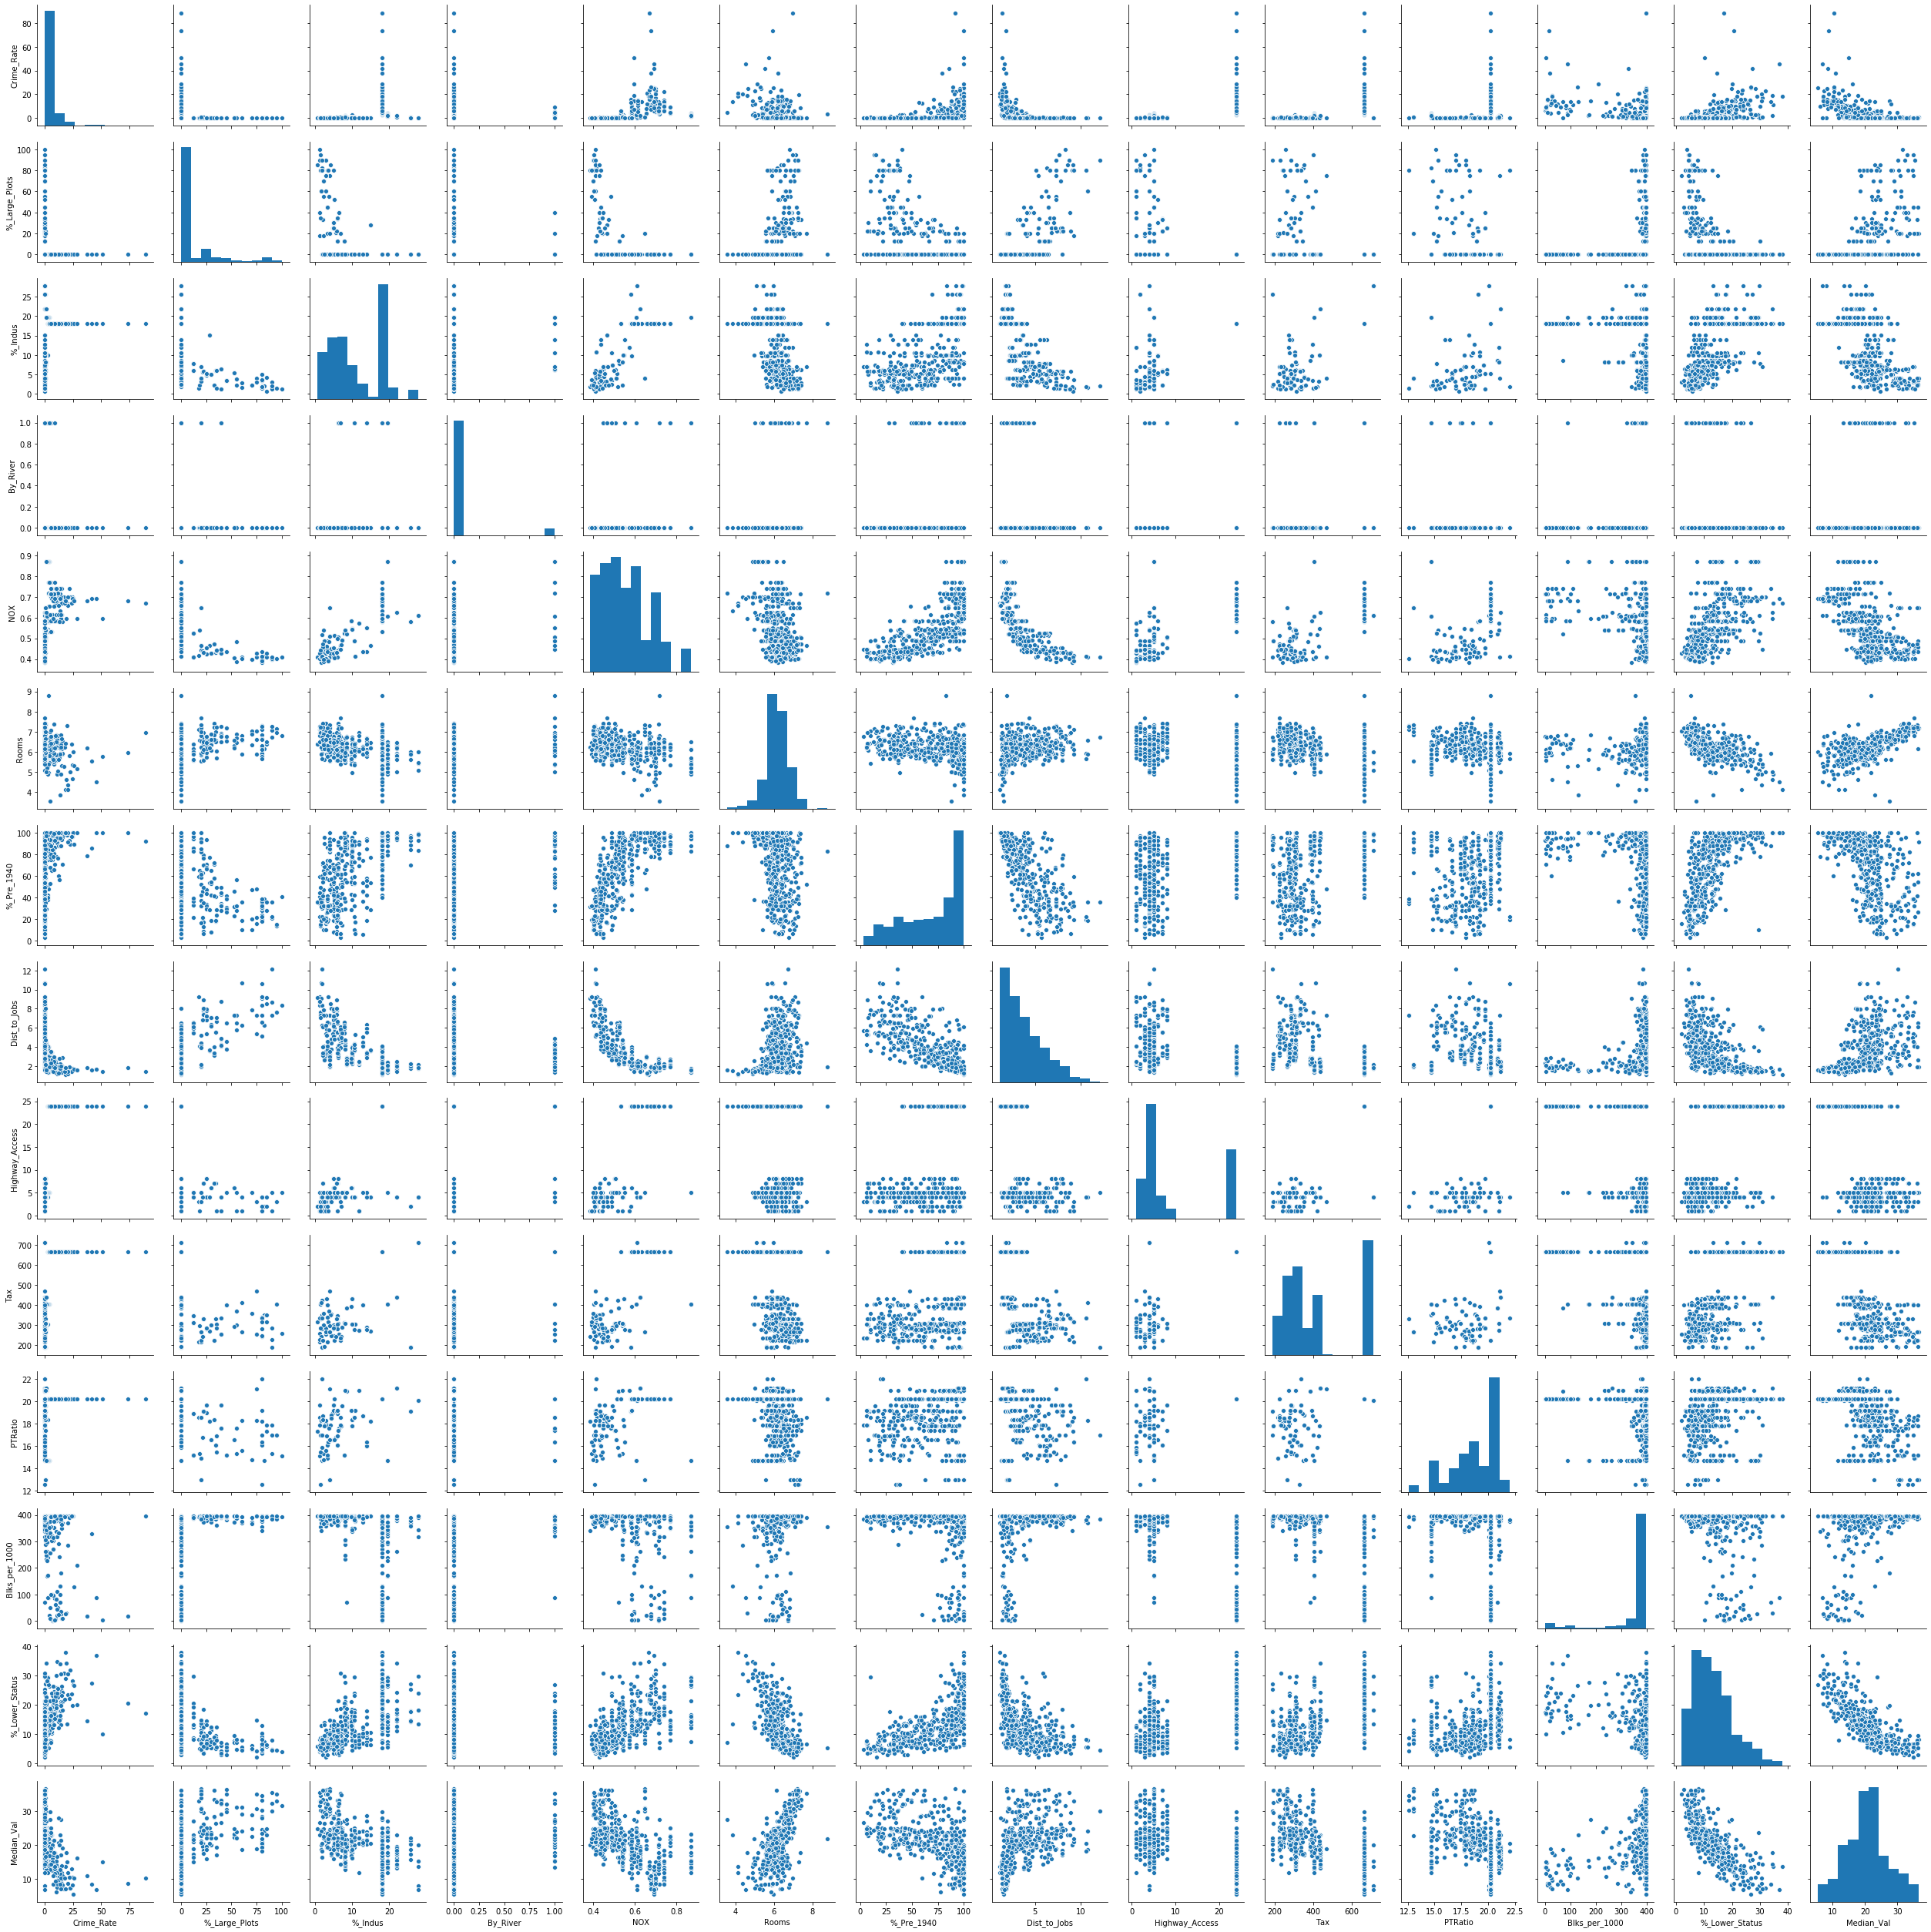

In [122]:
sns.pairplot(no_outliers)

### 4.5.2 Feature / Variable Selection

Another approach to tuning the model is feature selection. Feature selection can be used to identify and remove unneeded, irrelevant and redundant data that do not contribute to the accuracy of a predictive model [13]. If we were dealing with a larger dataset it would have the added benefit of being more cost-effective, and simpler to explain.

Generally speaking, the more features used in the model, the better the prediction will be. However, this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

### 4.5.2.1 Calculate the predictive power of each feature

#### Filter Method / Corrolation
One method of doing this is corrolation of each variable with the target variable. There should also be low corrolation between predictors or they should be merged. Corrolation is just one statistical measure that could be used. For example, a Chi Squared test is another option.

#### Wrapper Method

This approach treats the selection of features as a search problem. Different combinations of features are compared with other combinations with the combination that provides the best accuracy being used. 

#### Embedded Method

This just allows the algorithm to do it for you. Bad predictors are given a low weight with better predictors are given a higher weight.

In this project I have used the filter method to select my features.

#### 4.5.2.1.1 Filtering using Corrolation

We looked at corrolation between elements in the "Descriptive Analytics" section, but this was for the dataset before outliers were removed. The process now needs to be repeated.

In [ ]:
#Check no errors have been introduced
no_outliers.describe()

In [ ]:
noOutliers_corr_matrix = no_outliers.corr().round(2)
noOutliers_corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
no_median_val_corr = noOutliers_corr_matrix.iloc[-1]
no_median_val_corr.sort_values(ascending=True)

It seems like removing the outlier has had a big effect on the corrolation of some the features and the Median Value. With that in mind it may be a good idea to bring back all values except those at maximum Median Value of 50,000. I think it is best to continue to exclude these as 50,000 appears to be some kind of cap on the values. 

In [ ]:
fifty_plus_removed = df.loc[df['Median_Val'] < 49.9]
fifty_plus_removed.head()

In [ ]:
fifty_plus_removed.describe()

The new dataset remove the 16 rows where the median value was greater than 49,900, leaving 490.

In [ ]:
fiftyPlusRemoved_corr_matrix = fifty_plus_removed.corr().round(2)
fiftyPlusRemoved_corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
fifty_val_corr = fiftyPlusRemoved_corr_matrix.iloc[-1]
fifty_val_corr.sort_values(ascending=True)

With the Median Values of 50,000 removed the corrolations have changed slightly. However, the features with the highest corrolation are still the % of Lower Status people and the number of rooms in the house. % of Land zoned for industrial use, Tax, NOX and Parent Teacher ration are all also all have a corrolation of above 0.50. We need to double check to see if there is a relationship between these values and the Median Value.

In [ ]:
# getting highly corralted values
high_corr_features = fifty_plus_removed[["%_Lower_Status","Rooms","%_Indus","Tax","NOX","PTRatio","Median_Val"]]
high_corr_features.head()

In [ ]:
sns.pairplot(high_corr_features)

From looking at the right hand column of the pairplot above we can see that only % Lower Status and number of Rooms have an obvious relationship with the Median Value. Furthermore, Tax, the % Industrial, and NOX are all corrolated with eachother making them bad features to include in the model.

#### 4.5.2.1.2 Filtering using F_regression

This tests each feature to see which is the best predictor by calculating the corrolation between each feature and the target.

In [ ]:
# modification of chi squared test code found here:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
fregX = fifty_plus_removed.iloc[:, 0:13]  
fregy = fifty_plus_removed["Median_Val"]
fregX.head()

In [ ]:
bestfeatures = SelectKBest(score_func=f_regression, k=10) # show the top 10 best features
fregfit = bestfeatures.fit(fregX,fregy)
dfscores = pd.DataFrame(fregfit.scores_)
dfcolumns = pd.DataFrame(fregX.columns) 
fregfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)
fregfeatureScores.columns = ['Features','Score']  #naming the dataframe columns
print(fregfeatureScores.nlargest(10,'Score'))  #print 10 best features

As with the corrolation test, % Lower Status and Rooms are by far the best predictors.

### 4.5.2 Testing with Filtered Features

For our further testing we will only use the % Lower Status and Rooms features.

In [ ]:
filtered_features = fifty_plus_removed[["%_Lower_Status","Rooms","Median_Val"]]
filtered_features.head()

In [ ]:
# shuffle again and split into train and test
filtered_features = shuffle(filtered_features)

FFX = filtered_features.drop(labels=['Median_Val'], axis = 1)
FFy = filtered_features['Median_Val']

FFX_train, FFX_test, FFy_train, FFy_test = mod.train_test_split(FFX, FFy, test_size = 0.2)

In [ ]:
#check how many datapoints are in the train and test batches
FFX_train.shape, FFX_test.shape

In [ ]:
# new filtered features model
FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

In [ ]:
FFm.evaluate(FFX_test, FFy_test)

Initial results for the model using the filtered features are worse than the baseline, though the data has not been normalised yet. We will retest following doing this step next. 

#### 4.5.2.1 Filtered Features Normalisation

In [ ]:
scaler = pre.StandardScaler()
FFX_train = pd.DataFrame(scaler.fit_transform(FFX_train), columns=FFX.columns)
FFX_test = pd.DataFrame(scaler.transform(FFX_test), columns=FFX.columns)

In [ ]:
FFX_train.head()

In [ ]:
# model test with normalised input features 

FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

In [ ]:
FFm.evaluate(FFX_test, FFy_test)

Even after the normalization the performance of the model still fails to beat the baseline test where all 13 features where included.

#### 4.5.2.1 Filtered Features - Comparing Various Model Configurations

In [ ]:
# function to test various model configurations on the filter features dataset
def FF_tester(layer_size1, layer_size2, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(layer_size2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [ ]:
# big_all_adam = FF_tester(64,64,32,"adam") # large layers, large batches, adam optimizer
# big_all_adam

In [ ]:
# bigLayer_mediumbatch_adam = FF_tester(64,64,16,"adam") # large layers, large batches, adam optimizer
# bigLayer_smallbatch_adam = FF_tester(64,64,4,"adam")

In [ ]:
print(bigLayer_mediumbatch_adam)

In [ ]:
print(bigLayer_smallbatch_adam)

In [ ]:
# mediumLayer_bigbatch_adam = FF_tester(32,12,32,"adam")
# mediumLayer_mediumbatch_adam  = FF_tester(32,12,16,"adam")
# mediumLayer_smallbatch_adam  = FF_tester(32,12,4,"adam")

In [ ]:
print(mediumLayer_bigbatch_adam)
print(mediumLayer_mediumbatch_adam)
print(mediumLayer_smallbatch_adam)

In [ ]:
#smallLayer_bigbatch_adam  = FF_tester(12,6,32,"adam")
#smallLayer_mediumbatch_adam  = FF_tester(12,6,16,"adam")
#smallLayer_smallbatch_adam  = FF_tester(12,6,4,"adam")
# tinyLayer_smallbatch_adam = FF_tester(2,2,4,"adam")

In [ ]:
print(smallLayer_bigbatch_adam)
print(smallLayer_mediumbatch_adam)
print(smallLayer_smallbatch_adam)
print(tinyLayer_smallbatch_adam)

Medium layer sizes seems to peform the best. As a follow-up we will try the "rmsprop" optimiser.

In [ ]:
# mediumLayer_mediumbatch_rms  = FF_tester(32,12,16,"rmsprop")

In [ ]:
print(mediumLayer_mediumbatch_rms)

It didn't make an obvious difference and still isn't beating our original baseline test. Next I will try removing a layer.

In [ ]:
def FF_tester_1layer(layer_size1, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [ ]:
# hugelayer = FF_tester_1layer(64, 4, "adam")
# biglayer = FF_tester_1layer(32, 4, "adam")
# mediumlayer = FF_tester_1layer(12, 4, "adam")
# smalllayer = FF_tester_1layer(6, 4, "adam")


In [ ]:
print(hugelayer)
print(biglayer)
print(mediumlayer)
print(smalllayer)

Again, we don't seem to be making any drastic improvements and are still not beating the initial baseline test on all features. 

## 4.6 Conclusion and Final Model

In this final section we will retest the best performing models from above to determine the final model. For the retest we will use the dataset with all variables included, but with the samples that had a Median Value of 50,000 removed. 

In [ ]:
final_model_df = fifty_plus_removed
final_model_df.head()

In [ ]:
final_model_df = shuffle(final_model_df)
final_model_df

In [ ]:
FinalX = final_model_df.drop(labels=['Median_Val'], axis = 1)
Finaly = final_model_df['Median_Val']

FinalX_train, FinalX_test, Finaly_train, Finaly_test = mod.train_test_split(FinalX, Finaly, test_size = 0.2, random_state = 0)

In [ ]:
FinalX.head()

In [ ]:
scaler = pre.StandardScaler()
FinalX_train = pd.DataFrame(scaler.fit_transform(FinalX_train), columns=FinalX.columns)
FinalX_test = pd.DataFrame(scaler.transform(FinalX_test), columns=FinalX.columns)

In [ ]:
FinalX_train.head()

In [ ]:
#test final model option 1
def Final_tester(layer_size1, layer_size2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(layer_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(layer_size2, activation="relu"))
        m.add(ks.layers.Dense(1,activation="linear"))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=20, verbose=1)

        m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(FinalX_test, Finaly_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [ ]:
final_results = [
    Final_tester(13, 13),
    Final_tester(26, 26),
    Final_tester(26, 13),
    Final_tester(52, 26),
    Final_tester(64, 13)
]

In [ ]:
final_labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [ ]:
final_results_df = pd.DataFrame({'Tests': final_labels, 'Results': final_results})
final_results_df

# 5. References

1. Why Multicollinearity is bad https://en.wikipedia.org/wiki/Multicollinearity (why we exclude Tax, Highway_access, Dis_to_jobs, and %Pre_1940)


[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].

[13] Brownlee, J. (2019). An Introduction to Feature Selection. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/an-introduction-to-feature-selection/ [Accessed 4 Dec. 2019].

[14] Chandrayan, P. (2019). Hypothesis Testing Using T Test : Inferential Statistics Part3. [online] Medium. Available at: https://towardsdatascience.com/hypothesis-testing-using-t-test-inferential-statistics-part3-6fb43683bc32 [Accessed 12 Dec. 2019].

[15] Brownlee, J. (2019). A Gentle Introduction to Normality Tests in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/ [Accessed 30 Oct. 2019].